In [1]:
#from mpl_toolkits.basemap import Basemap, cm
import os.path
import os
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import numpy as np
import numpy.ma as ma
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import scipy.ndimage as ndimage
import scipy.signal as signal

from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dewpoint_from_relative_humidity, dry_lapse, moist_lapse,
                        vapor_pressure, saturation_vapor_pressure, wind_speed, wind_direction, pressure_to_height_std,
                        mixing_ratio, cape_cin, wind_components, height_to_pressure_std, equivalent_potential_temperature,
                        parcel_profile, precipitable_water, storm_relative_helicity, mean_pressure_weighted, 
                        most_unstable_cape_cin, most_unstable_parcel, supercell_composite, significant_tornado, get_layer,
                        relative_humidity_from_dewpoint, surface_based_cape_cin, mixed_layer_cape_cin, el, cape_cin,
                        surface_based_cape_cin, potential_temperature, wind_direction, add_pressure_to_height,
                        add_height_to_pressure, divergence, vorticity, lat_lon_grid_deltas, mixed_parcel,
                        most_unstable_parcel, lcl, lfc, mixing_ratio_from_relative_humidity, virtual_potential_temperature,
                        frontogenesis)

from metpy.units import units
from metpy.plots import SkewT
from metpy.plots import Hodograph
from metpy.interpolate import interpolate_1d as metinterp
from metpy.interpolate import log_interpolate_1d
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel, PanelContainer, PlotObs)

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv
import pandas as pd
import xarray as xr
import math

import glob
import matplotlib.colors as colors
import s3fs

D:\Anaconda3\envs\THESIS\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [54]:
from metpy.interpolate import log_interpolate_1d

In [2]:
import dataclasses
import datetime

@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        if self.model_type == "fcst": 
            # Extra id part since forecasts have an additional (time) dimension
            return "0." + str(chunk_id)
        else:
            return chunk_id
        
#CHUNKS FOR 5/22: 2.5, 2.6, 3.5, 3.6

fs = s3fs.S3FileSystem(anon=True) 

def load(url, run_hour=None, new_time_dimension=None):
    # Download the data from S3. May be lazy.
    ds = xr.open_dataset(s3fs.S3Map(url, s3=fs), engine="zarr")
    
    # Add the model run hour in as a dimension
    if run_hour is not None:
        ds[new_time_dimension] = run_hour
        ds = ds.set_coords(new_time_dimension)
    
    # Later on we use metpy functions that expect the grid variables to be x and y
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    return ds

def load_combined_dataset(zarr_ids):
    
    # Get the grid data (at a long forecast hour in case the whole time dim is needed)
    grid_zarr_id = dataclasses.replace(zarr_ids[0]) # dataclasses.replace is just a fancy copy function
    grid_zarr_id.run_hour = grid_zarr_id.run_hour.replace(hour=0)  
    grid = load(create_s3_group_url(grid_zarr_id))
    
    is_forecast = zarr_ids[0].model_type == "fcst"
    new_time_dimension = "reference_time" if is_forecast else "time"
    
    datasets = [load(create_s3_subgroup_url(zarr_id), zarr_id.run_hour, new_time_dimension) 
                for zarr_id in zarr_ids]
    
    if is_forecast: # Align the time axes of each dataset (b/c forecasts have different lengths)
        for dataset in datasets:
            dataset["time"] = grid["time"][:len(dataset["time"])]
        datasets = xr.align(*datasets, join="outer")
        
    ds = xr.concat(datasets, dim=new_time_dimension, combine_attrs="override")
    
    # Add the geospatial data to the combined dataset
    ds["x"] = grid["x"]
    ds["y"] = grid["y"]  
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    
    return ds

def create_s3_group_url(zarr_id, prefix=True):
    url = "s3://hrrrzarr/" if prefix else "" # Skip when using boto3
    url += zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}"
    return url

def create_s3_subgroup_url(zarr_id, prefix=True):
    url = create_s3_group_url(zarr_id, prefix)
    url += f"/{zarr_id.var_level}"
    return url

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=20):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,semiminor_axis=6371229))

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [24]:
reader = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
proj = ccrs.PlateCarree()

reader_w= shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e= shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = list(reader_w.geometries())
watch_E = list(reader_e.geometries())
watch_W = cfeature.ShapelyFeature(watch_W, ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(watch_E, ccrs.PlateCarree())

#lat1 = pd.read_csv(r"C:\Users\kyled\Desktop\HRRROuts\lat.csv",header = None)
#lon1 = pd.read_csv(r"C:\Users\kyled\Desktop\HRRROuts\lon.csv",header = None)

lat1 = lat[327:513, 790:1040]
lon1 = lon[327:513, 790:1040]

hours = ["20", "21", "22", "23", "0", "1", "2", "3", "4"]

In [74]:
year=2019
month=5
day = 23
hour = 3
##############################
run_hour=datetime.datetime(year, month, day, hour)
zarr_ids = [ZarrId(
                run_hour=datetime.datetime(year, month, day, hour) + datetime.timedelta(hours=time_delta),
                level_type="sfc",
                var_level="entire_atmosphere",
                var_name="REFC",
                model_type="anl"
                )
            for time_delta in range(3)] # get 3 hours starting at the given time

dat = load_combined_dataset(zarr_ids)

Hour = hour

time_start = datetime.datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
else:
    hour=str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
else:
    day=str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)
else:
    month=str(month)
year=str(year)

timeIN=str(year+month+day)

fs = s3fs.S3FileSystem(anon=True)
#fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.20190522/conus/')
files = np.array(fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/'))
fileN = np.where(files=='noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/hrrr.t'+hour+'z.wrfnatf00.grib2')
fs.get(files[fileN[0][0]], files[fileN[0][0]].split('/')[-1])
fname=files[fileN[0][0]].split('/')[-1]
c=xr.open_dataset(fname, filter_by_keys={'typeOfLevel': 'hybrid'})
print(fname, "\n")

lev=np.asarray(c.variables['hybrid'][:]) # 0 = lowest level, 49 = highest level
lat=np.asarray(c.variables['latitude'])
lon=((np.asarray(c.variables['longitude'])*-1)+360)*-1

T=np.asarray(c.variables['t'][:]) #K #temperature
q=np.asarray(c.variables['q'][:]) # kg kg**-1 #specific humidity
uwnd=np.asarray(c.variables['u'][:]) #m/s #u wind
vwnd=np.asarray(c.variables['v'][:]) #m/s #v wind
hgt=np.asarray(c.variables['gh'][:]) #geopotential meters #geopotential height
sfc_hgt=np.asarray(c.variables['gh'][0])
VVEL_up=(np.asarray(c.variables['w'][:])) #Pa s**-1 #vertical velocity  
lev=(np.asarray(c.variables['pres'][:])/100.) #hPa #pressure
#Td=dewpoint_from_specific_humidity(lev* units('hPa'),T* units('kelvin'),q)
#TE = equivalent_potential_temperature(lev* units('hPa'), T* units('kelvin'), Td)


#p = lev * units.hPa
u = uwnd * units('m/s')
v = vwnd * units('m/s')

#target_p = 700 * units.hPa

# Interpolate u and v at each (lat, lon)
#u_700 = log_interpolate_1d(target_p, p, u, axis=0)
#v_700 = log_interpolate_1d(target_p, p, v, axis=0)

#u700_export = np.asarray(u_700[0][327:513,790:1040])
#v700_export = np.asarray(v_700[0][327:513,790:1040])

uSFC_export = np.asarray(u[0][327:513,790:1040])
vSFC_export = np.asarray(v[0][327:513,790:1040])

#np.savetxt(r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_u_700.csv",u700_export,delimiter=",",fmt='%s')
#np.savetxt(r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_v_700.csv",v700_export,delimiter=",",fmt='%s')

np.savetxt(r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_u_SFC.csv",uSFC_export,delimiter=",",fmt='%s')
np.savetxt(r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_v_SFC.csv",vSFC_export,delimiter=",",fmt='%s')

hrrr.t03z.wrfnatf00.grib2 



In [66]:
uSFC_export = np.asarray(u[0][327:513,790:1040])
vSFC_export = np.asarray(v[0][327:513,790:1040])

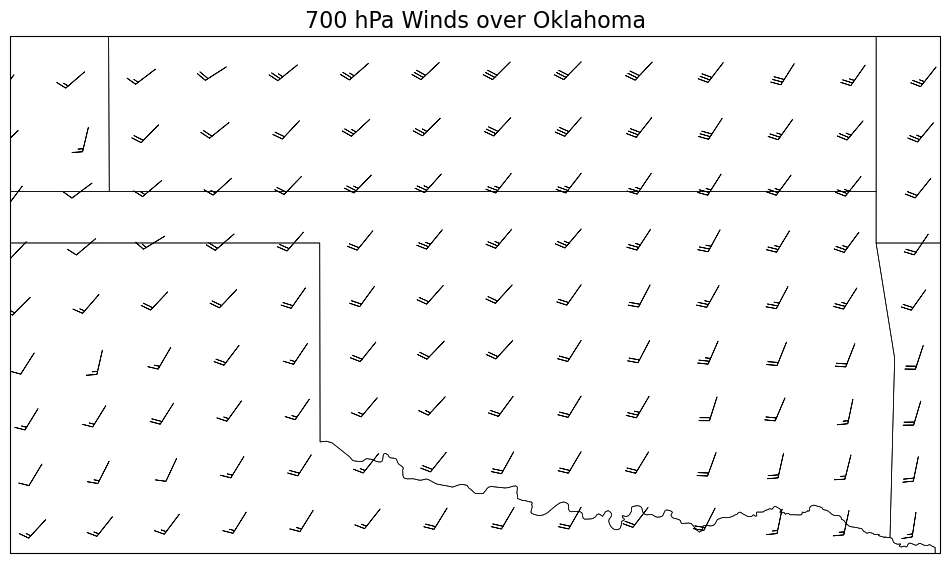

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Strip the first dimension (time) from u and v wind fields
u_700_2d = u_700[0]  # shape becomes (1059, 1799)
v_700_2d = v_700[0]

# Define bounding box for Oklahoma
lat_min, lat_max = 33.5, 38.5
lon_min, lon_max = -103, -94

# Create mask over bounding box
mask = (
    (lat >= lat_min) & (lat <= lat_max) &
    (lon >= lon_min) & (lon <= lon_max)
)

# Mask the arrays
u_masked = np.where(mask, u_700_2d.magnitude, np.nan)
v_masked = np.where(mask, v_700_2d.magnitude, np.nan)
lat_masked = np.where(mask, lat, np.nan)
lon_masked = np.where(mask, lon, np.nan)

# Downsample to avoid cluttered barbs
step = 20  # adjust as needed
u_plot = u_masked[::step, ::step]
v_plot = v_masked[::step, ::step]
lat_plot = lat_masked[::step, ::step]
lon_plot = lon_masked[::step, ::step]

# Plotting
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Wind barbs
ax.barbs(lon_plot, lat_plot, u_plot, v_plot, length=6, linewidth=0.6)

ax.set_title('700 hPa Winds over Oklahoma', fontsize=16)
plt.show()


In [23]:
np.max(lon1)

-92.71478328164056

In [15]:
print(f"{label} — {len(prof_subset)} profiles")

NameError: name 'label' is not defined

In [10]:
csv_path = r'D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_20\hr20_mean2500m_5km_RH.csv'

In [11]:
df = pd.read_csv(csv_path, header=None)

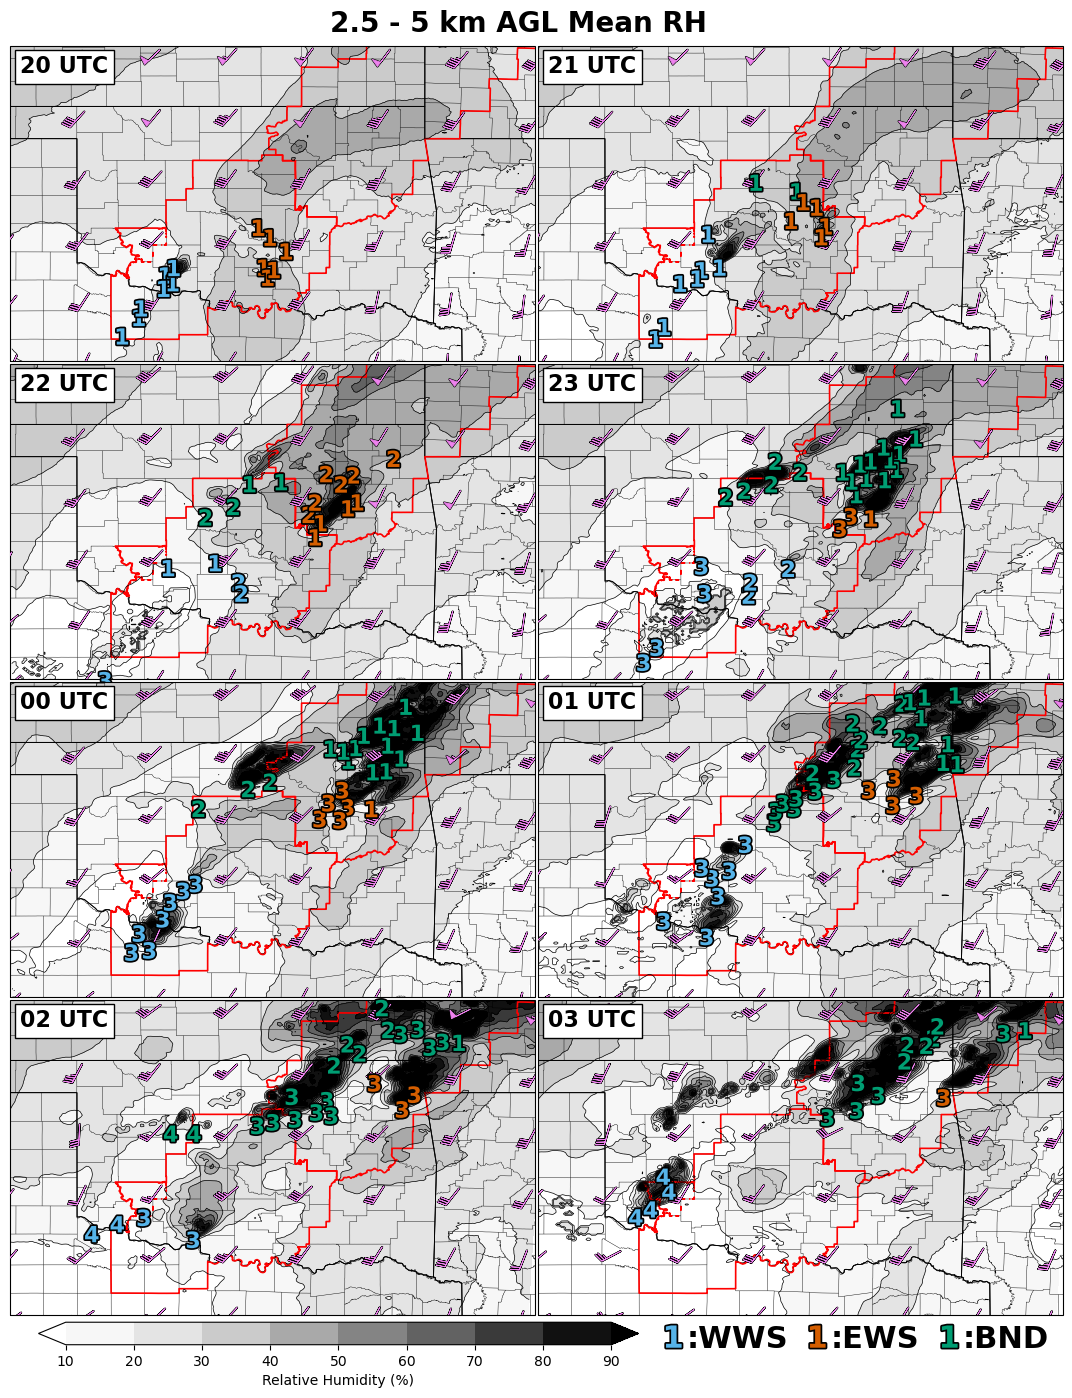

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
from matplotlib.patheffects import withStroke
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import os

profile_df = pd.read_csv(r"D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\5_22_VerticalProfs_QC_Grouped_REVISED.csv")
#current_hour = int(label.split()[0])  # "20 UTC" → 20
#prof_subset = profile_df[profile_df['Time'] == current_hour]

# Load custom shapefiles
reader = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader_w = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = cfeature.ShapelyFeature(list(reader_w.geometries()), ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(list(reader_e.geometries()), ccrs.PlateCarree())

# RH file paths
rh_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_20\hr20_mean2500m_5km_RH.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_21\hr21_mean2500m_5km_RH.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_22\hr22_mean2500m_5km_RH.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_23\hr23_mean2500m_5km_RH.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_0\hr00_mean2500m_5km_RH.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_1\hr01_mean2500m_5km_RH.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_2\hr02_mean2500m_5km_RH.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_3\hr03_mean2500m_5km_RH.csv"
]

# Wind data (u and v components in knots)
u_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_u_700.csv"
]

v_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_v_700.csv"
]


# Hour labels for corner annotation
hour_labels = ["20 UTC", "21 UTC", "22 UTC", "23 UTC", "00 UTC", "01 UTC", "02 UTC", "03 UTC"]

# Set up figure
fig = plt.figure(figsize=(12, 15))
projection = ccrs.PlateCarree()

# Define domain extent
extent = [np.min(lon1)+0.2, np.max(lon1)-0.2, np.min(lat1)+0.1, np.max(lat1)-0.1]

barb_style = dict(path_effects=[withStroke(linewidth=1.5, foreground="white")])

# Manual subplot placement (2 columns x 4 rows)
ncols, nrows = 2, 4
panel_width = 0.45
panel_height = 0.21
left_margin = 0.07
bottom_margin = 0.09
hspace = 0.002
wspace = -0.01

for idx, (rh_file, label) in enumerate(zip(rh_files, hour_labels)):
    col = idx % ncols
    row = idx // ncols
    left = left_margin + col * (panel_width + wspace)
    bottom = bottom_margin + (nrows - 1 - row) * (panel_height + hspace)

    ax = fig.add_axes([left, bottom, panel_width, panel_height], projection=projection)
    ax.set_extent(extent)

    rh = np.loadtxt(rh_file, delimiter=',')
    u = np.loadtxt(u_files[idx], delimiter=',')* 1.94384
    v = np.loadtxt(v_files[idx], delimiter=',')* 1.94384
    #mesh = ax.pcolormesh(lon1, lat1, rh, cmap='Greys', shading='auto', vmin=0, vmax=90)
    
    levels = np.arange(10, 100, 10)  # define 10% spaced levels for contours

    # Filled contours
    mesh = ax.contourf(lon1, lat1, rh, levels=levels, cmap='Greys', extend='both', transform=ccrs.PlateCarree())

    # Line contours
    contours = ax.contour(lon1, lat1, rh, levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    #ax.clabel(contours, inline=True, fontsize=7, fmt='%d', colors='black')  # optional labels on lines

    stride = 35
    ax.barbs(
        lon1[::stride, ::stride], lat1[::stride, ::stride],
        u[::stride, ::stride], v[::stride, ::stride],
        length=5.5, linewidth=0.6, barbcolor='violet', pivot='middle', zorder=10,
        transform=ccrs.PlateCarree()
        ,path_effects=[withStroke(linewidth=1.5, foreground="black")]
    )

    # Map features
    ax.add_feature(cfeature.STATES, linewidth=0.6)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.3)
    ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=1.2)
    ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=1.2)

    # Time label
    ax.text(0.02, 0.97, label, transform=ax.transAxes,
            ha='left', va='top', fontsize=16, fontweight='bold',
            bbox=dict(facecolor='white', alpha=1.0, edgecolor='black'), zorder=11)
    
    current_hour = int(label.split()[0])  # Extracts 20 from "20 UTC"
    prof_subset = profile_df[profile_df['Time'] == current_hour]

    for _, prof_row in prof_subset.iterrows():
        group = prof_row['Grouping']
        lat = prof_row['Lat']
        lon = prof_row['Lon']

        if isinstance(group, str):
            # Set color based on prefix
            if group.startswith('OPW'):
                color = '#56B4E9'
            elif group.startswith('OPE'):
                color = '#D55E00'
            elif group.startswith('BDW') or group.startswith('BDE'):
                color = '#009E73'
            else:
                color = 'black'

            # Plot the numeric part of the group
            number = ''.join(filter(str.isdigit, group))
            if number:
                lon_adj = lon
                lat_adj = lat
                buffer_deg = 0.2
                
                if lon < extent[0] + buffer_deg:
                    lon_adj += buffer_deg
                elif lon > extent[1] - buffer_deg:
                    lon_adj -= buffer_deg

                if lat < extent[2] + buffer_deg:
                    lat_adj += buffer_deg
                elif lat > extent[3] - buffer_deg:
                    lat_adj -= buffer_deg
                
                txt = ax.text(
                    lon_adj, lat_adj, number, fontsize=16, fontweight='bold', color=color,
                    ha='center', va='center', transform=ccrs.PlateCarree(), zorder=12
                )
                txt.set_path_effects([
                    path_effects.Stroke(linewidth=2.5, foreground='black'),
                    path_effects.Normal()
                ])

# Manually placed colorbar
cax = fig.add_axes([0.10, 0.07, 0.5, 0.015])
cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', label='Relative Humidity (%)')

outline = [path_effects.Stroke(linewidth=2.5, foreground='black'), path_effects.Normal()]

# Add the base text (group labels in black)
fig.text(0.64, 0.068, ":WWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.76, 0.068, ":EWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.87, 0.068, ":BND", fontsize=22, fontweight='bold', color='black')

# Overlay colored numbers with outlines
fig.text(0.62, 0.068, "1", fontsize=22, fontweight='bold', color='#56B4E9', path_effects=outline)    # OPW
fig.text(0.74, 0.068, "1", fontsize=22, fontweight='bold', color='#D55E00', path_effects=outline)  # OPE
fig.text(0.85, 0.068, "1", fontsize=22, fontweight='bold', color='#009E73', path_effects=outline)   # BDW/BDE

# Add centered main title
fig.suptitle("2.5 - 5 km AGL Mean RH", fontsize=20, fontweight="bold", y=0.96)

plt.show()

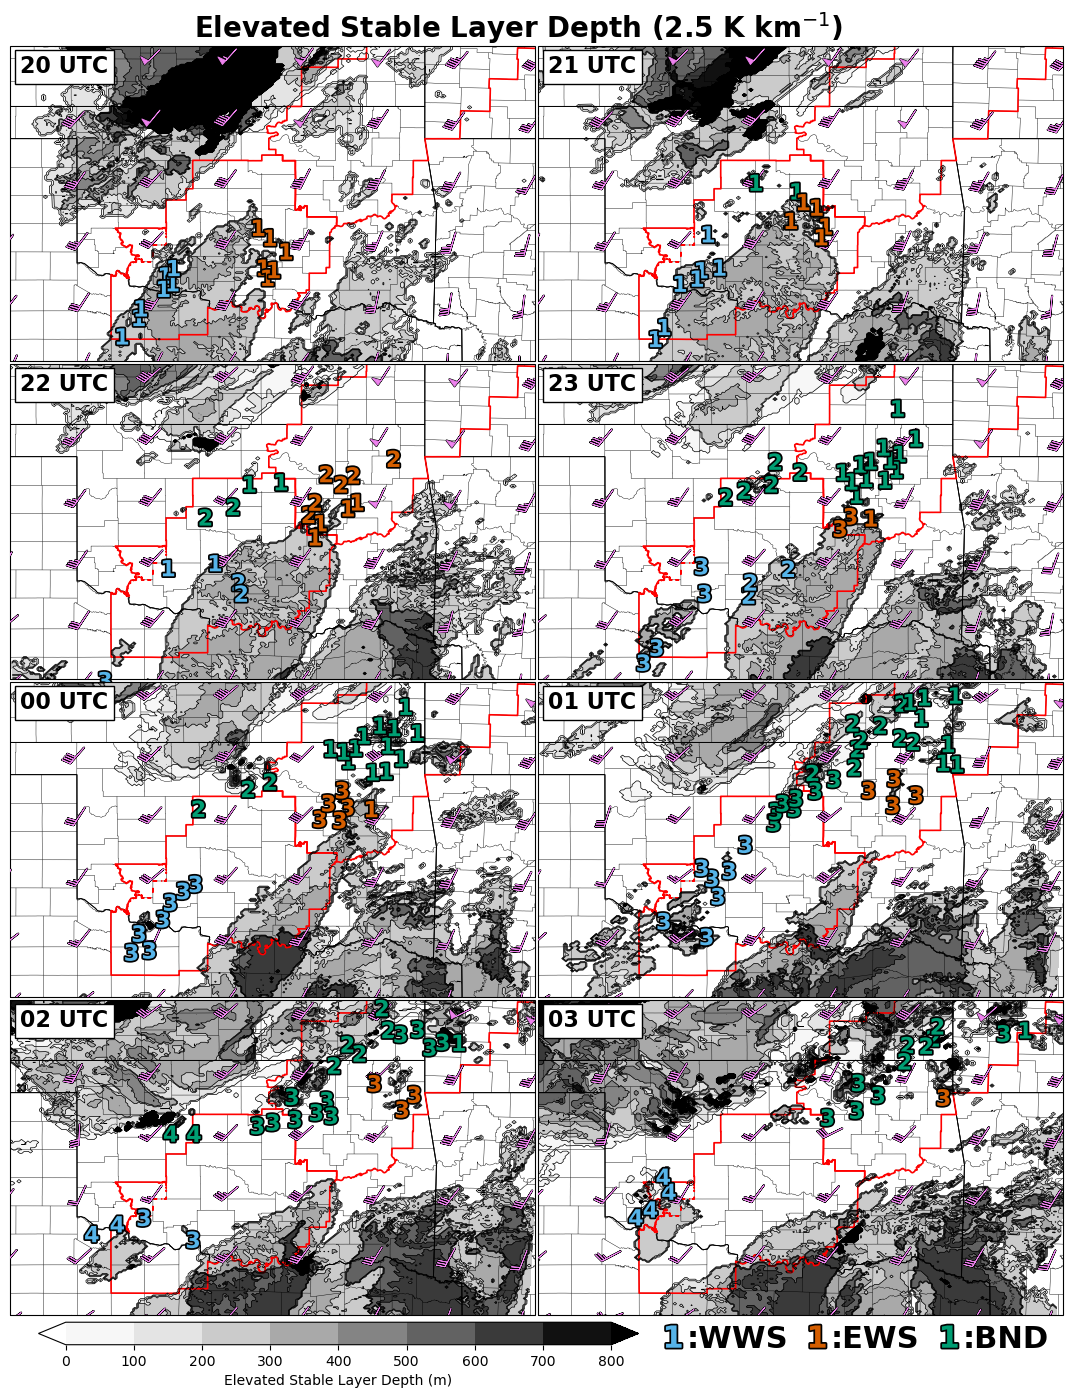

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
from matplotlib.patheffects import withStroke
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import os

profile_df = pd.read_csv(r"D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\5_22_VerticalProfs_QC_Grouped_REVISED.csv")
current_hour = int(label.split()[0])  # "20 UTC" → 20
prof_subset = profile_df[profile_df['Time'] == current_hour]

# Load custom shapefiles
reader = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader_w = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = cfeature.ShapelyFeature(list(reader_w.geometries()), ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(list(reader_e.geometries()), ccrs.PlateCarree())

# RH file paths
rh_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_20\hr20_Inhibition_3_ESL25.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_21\hr21_Inhibition_3_ESL25.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_22\hr22_Inhibition_3_ESL25.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_23\hr23_Inhibition_3_ESL25.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_0\hr00_Inhibition_3_ESL25.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_1\hr01_Inhibition_3_ESL25.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_2\hr02_Inhibition_3_ESL25.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_3\hr03_Inhibition_3_ESL25.csv"
]

# Wind data (u and v components in knots)
u_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_u_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_u_700.csv"
]

v_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_v_700.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_v_700.csv"
]



# Hour labels for corner annotation
hour_labels = ["20 UTC", "21 UTC", "22 UTC", "23 UTC", "00 UTC", "01 UTC", "02 UTC", "03 UTC"]

# Set up figure
fig = plt.figure(figsize=(12, 15))
projection = ccrs.PlateCarree()

# Define domain extent
extent = [np.min(lon1)+0.2, np.max(lon1)-0.2, np.min(lat1)+0.1, np.max(lat1)-0.1]

barb_style = dict(path_effects=[withStroke(linewidth=1.5, foreground="white")])

# Manual subplot placement (2 columns x 4 rows)
ncols, nrows = 2, 4
panel_width = 0.45
panel_height = 0.21
left_margin = 0.07
bottom_margin = 0.09
hspace = 0.002
wspace = -0.01

for idx, (rh_file, label) in enumerate(zip(rh_files, hour_labels)):
    col = idx % ncols
    row = idx // ncols
    left = left_margin + col * (panel_width + wspace)
    bottom = bottom_margin + (nrows - 1 - row) * (panel_height + hspace)

    ax = fig.add_axes([left, bottom, panel_width, panel_height], projection=projection)
    ax.set_extent(extent)

    rh = np.loadtxt(rh_file, delimiter=',')
    u = np.loadtxt(u_files[idx], delimiter=',')* 1.94384
    v = np.loadtxt(v_files[idx], delimiter=',')* 1.94384
    #mesh = ax.pcolormesh(lon1, lat1, rh, cmap='Greys', shading='auto', vmin=0, vmax=90)
    
    levels = np.arange(0, 900, 100)  # define 10% spaced levels for contours

    # Filled contours
    mesh = ax.contourf(lon1, lat1, rh, levels=levels, cmap='Greys', extend='both', transform=ccrs.PlateCarree())

    # Line contours
    contours = ax.contour(lon1, lat1, rh, levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    #ax.clabel(contours, inline=True, fontsize=7, fmt='%d', colors='black')  # optional labels on lines

    stride = 35
    ax.barbs(
        lon1[::stride, ::stride], lat1[::stride, ::stride],
        u[::stride, ::stride], v[::stride, ::stride],
        length=5.5, linewidth=0.6, barbcolor='violet', pivot='middle', zorder=10,
        transform=ccrs.PlateCarree()
        ,path_effects=[withStroke(linewidth=1.5, foreground="black")]
    )

    # Map features
    ax.add_feature(cfeature.STATES, linewidth=0.6)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.3)
    ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=1.2)
    ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=1.2)

    # Time label
    ax.text(0.02, 0.97, label, transform=ax.transAxes,
            ha='left', va='top', fontsize=16, fontweight='bold',
            bbox=dict(facecolor='white', alpha=1.0, edgecolor='black'), zorder=11)
    
    current_hour = int(label.split()[0])  # Extracts 20 from "20 UTC"
    prof_subset = profile_df[profile_df['Time'] == current_hour]

    for _, prof_row in prof_subset.iterrows():
        group = prof_row['Grouping']
        lat = prof_row['Lat']
        lon = prof_row['Lon']

        if isinstance(group, str):
            # Set color based on prefix
            if group.startswith('OPW'):
                color = '#56B4E9'
            elif group.startswith('OPE'):
                color = '#D55E00'
            elif group.startswith('BDW') or group.startswith('BDE'):
                color = '#009E73'
            else:
                color = 'black'

            # Plot the numeric part of the group
            number = ''.join(filter(str.isdigit, group))
            if number:
                lon_adj = lon
                lat_adj = lat
                buffer_deg = 0.2
                
                if lon < extent[0] + buffer_deg:
                    lon_adj += buffer_deg
                elif lon > extent[1] - buffer_deg:
                    lon_adj -= buffer_deg

                if lat < extent[2] + buffer_deg:
                    lat_adj += buffer_deg
                elif lat > extent[3] - buffer_deg:
                    lat_adj -= buffer_deg
                
                txt = ax.text(
                    lon_adj, lat_adj, number, fontsize=16, fontweight='bold', color=color,
                    ha='center', va='center', transform=ccrs.PlateCarree(), zorder=12
                )
                txt.set_path_effects([
                    path_effects.Stroke(linewidth=2.5, foreground='black'),
                    path_effects.Normal()
                ])

# Manually placed colorbar
cax = fig.add_axes([0.10, 0.07, 0.5, 0.015])
cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', label='Elevated Stable Layer Depth (m)')

outline = [path_effects.Stroke(linewidth=2.5, foreground='black'), path_effects.Normal()]

# Add the base text (group labels in black)
fig.text(0.64, 0.068, ":WWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.76, 0.068, ":EWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.87, 0.068, ":BND", fontsize=22, fontweight='bold', color='black')

# Overlay colored numbers with outlines
fig.text(0.62, 0.068, "1", fontsize=22, fontweight='bold', color='#56B4E9', path_effects=outline)    # OPW
fig.text(0.74, 0.068, "1", fontsize=22, fontweight='bold', color='#D55E00', path_effects=outline)  # OPE
fig.text(0.85, 0.068, "1", fontsize=22, fontweight='bold', color='#009E73', path_effects=outline)   # BDW/BDE

# Add centered main title
#fig.suptitle("Elevated Stable Layer Depth (2.5 K/km)", fontsize=20, fontweight="bold", y=0.96)
fig.suptitle(r"Elevated Stable Layer Depth (2.5 K km$^{-1}$)", fontsize=20, fontweight="bold", y=0.96)


plt.show()

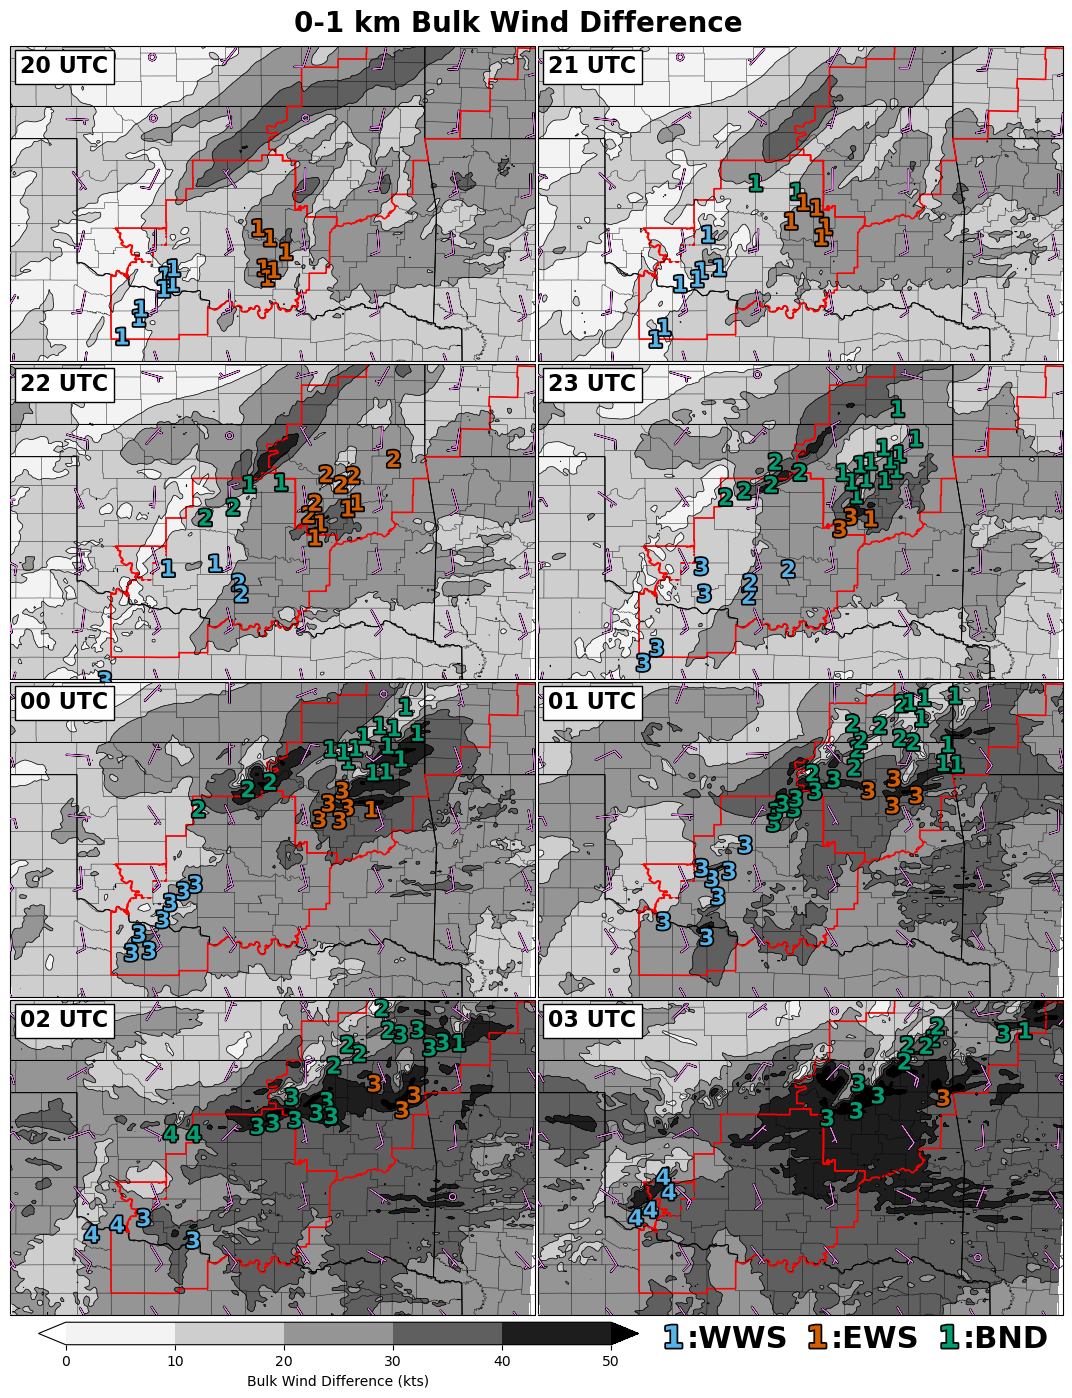

In [79]:

profile_df = pd.read_csv(r"D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\5_22_VerticalProfs_QC_Grouped_REVISED.csv")
current_hour = int(label.split()[0])  # "20 UTC" → 20
prof_subset = profile_df[profile_df['Time'] == current_hour]

# Load custom shapefiles
reader = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader_w = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = cfeature.ShapelyFeature(list(reader_w.geometries()), ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(list(reader_e.geometries()), ccrs.PlateCarree())

# RH file paths
rh_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_20\hr20_BulkShear_0_0_1_km_BWD.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_21\hr21_BulkShear_0_0_1_km_BWD.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_22\hr22_BulkShear_0_0_1_km_BWD.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_23\hr23_BulkShear_0_0_1_km_BWD.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_0\hr00_BulkShear_0_0_1_km_BWD.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_1\hr01_BulkShear_0_0_1_km_BWD.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_2\hr02_BulkShear_0_0_1_km_BWD.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\Hourly_Array_3\hr03_BulkShear_0_0_1_km_BWD.csv"
]

# Wind data (u and v components in knots)
u_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_u_SFC.csv"
]

v_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_v_SFC.csv"
]



# Hour labels for corner annotation
hour_labels = ["20 UTC", "21 UTC", "22 UTC", "23 UTC", "00 UTC", "01 UTC", "02 UTC", "03 UTC"]

# Set up figure
fig = plt.figure(figsize=(12, 15))
projection = ccrs.PlateCarree()

# Define domain extent
extent = [np.min(lon1)+0.2, np.max(lon1)-0.2, np.min(lat1)+0.1, np.max(lat1)-0.1]

barb_style = dict(path_effects=[withStroke(linewidth=1.5, foreground="white")])

# Manual subplot placement (2 columns x 4 rows)
ncols, nrows = 2, 4
panel_width = 0.45
panel_height = 0.21
left_margin = 0.07
bottom_margin = 0.09
hspace = 0.002
wspace = -0.01

for idx, (rh_file, label) in enumerate(zip(rh_files, hour_labels)):
    col = idx % ncols
    row = idx // ncols
    left = left_margin + col * (panel_width + wspace)
    bottom = bottom_margin + (nrows - 1 - row) * (panel_height + hspace)

    ax = fig.add_axes([left, bottom, panel_width, panel_height], projection=projection)
    ax.set_extent(extent)

    rh = np.loadtxt(rh_file, delimiter=',')
    u = np.loadtxt(u_files[idx], delimiter=',')* 1.94384
    v = np.loadtxt(v_files[idx], delimiter=',')* 1.94384
    #mesh = ax.pcolormesh(lon1, lat1, rh, cmap='Greys', shading='auto', vmin=0, vmax=90)
    
    levels = np.arange(0, 60, 10)  # define 10% spaced levels for contours

    # Filled contours
    mesh = ax.contourf(lon1, lat1, rh, levels=levels, cmap='Greys', extend='both', transform=ccrs.PlateCarree())

    # Line contours
    contours = ax.contour(lon1, lat1, rh, levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    #ax.clabel(contours, inline=True, fontsize=7, fmt='%d', colors='black')  # optional labels on lines

    stride = 35
    ax.barbs(
        lon1[::stride, ::stride], lat1[::stride, ::stride],
        u[::stride, ::stride], v[::stride, ::stride],
        length=5.5, linewidth=0.6, barbcolor='violet', pivot='middle', zorder=10,
        transform=ccrs.PlateCarree()
        ,path_effects=[withStroke(linewidth=1.5, foreground="black")]
    )

    # Map features
    ax.add_feature(cfeature.STATES, linewidth=0.6)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.3)
    ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=1.2)
    ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=1.2)

    # Time label
    ax.text(0.02, 0.97, label, transform=ax.transAxes,
            ha='left', va='top', fontsize=16, fontweight='bold',
            bbox=dict(facecolor='white', alpha=1.0, edgecolor='black'), zorder=11)
    
    current_hour = int(label.split()[0])  # Extracts 20 from "20 UTC"
    prof_subset = profile_df[profile_df['Time'] == current_hour]

    for _, prof_row in prof_subset.iterrows():
        group = prof_row['Grouping']
        lat = prof_row['Lat']
        lon = prof_row['Lon']

        if isinstance(group, str):
            # Set color based on prefix
            if group.startswith('OPW'):
                color = '#56B4E9'
            elif group.startswith('OPE'):
                color = '#D55E00'
            elif group.startswith('BDW') or group.startswith('BDE'):
                color = '#009E73'
            else:
                color = 'black'

            # Plot the numeric part of the group
            number = ''.join(filter(str.isdigit, group))
            if number:
                lon_adj = lon
                lat_adj = lat
                buffer_deg = 0.2
                
                if lon < extent[0] + buffer_deg:
                    lon_adj += buffer_deg
                elif lon > extent[1] - buffer_deg:
                    lon_adj -= buffer_deg

                if lat < extent[2] + buffer_deg:
                    lat_adj += buffer_deg
                elif lat > extent[3] - buffer_deg:
                    lat_adj -= buffer_deg
                
                txt = ax.text(
                    lon_adj, lat_adj, number, fontsize=16, fontweight='bold', color=color,
                    ha='center', va='center', transform=ccrs.PlateCarree(), zorder=12
                )
                txt.set_path_effects([
                    path_effects.Stroke(linewidth=2.5, foreground='black'),
                    path_effects.Normal()
                ])

# Manually placed colorbar
cax = fig.add_axes([0.10, 0.07, 0.5, 0.015])
cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', label='Bulk Wind Difference (kts)')

outline = [path_effects.Stroke(linewidth=2.5, foreground='black'), path_effects.Normal()]

# Add the base text (group labels in black)
fig.text(0.64, 0.068, ":WWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.76, 0.068, ":EWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.87, 0.068, ":BND", fontsize=22, fontweight='bold', color='black')

# Overlay colored numbers with outlines
fig.text(0.62, 0.068, "1", fontsize=22, fontweight='bold', color='#56B4E9', path_effects=outline)    # OPW
fig.text(0.74, 0.068, "1", fontsize=22, fontweight='bold', color='#D55E00', path_effects=outline)  # OPE
fig.text(0.85, 0.068, "1", fontsize=22, fontweight='bold', color='#009E73', path_effects=outline)   # BDW/BDE

# Add centered main title
#fig.suptitle("Elevated Stable Layer Depth (2.5 K/km)", fontsize=20, fontweight="bold", y=0.96)
fig.suptitle(r"0-1 km Bulk Wind Difference", fontsize=20, fontweight="bold", y=0.96)


plt.show()

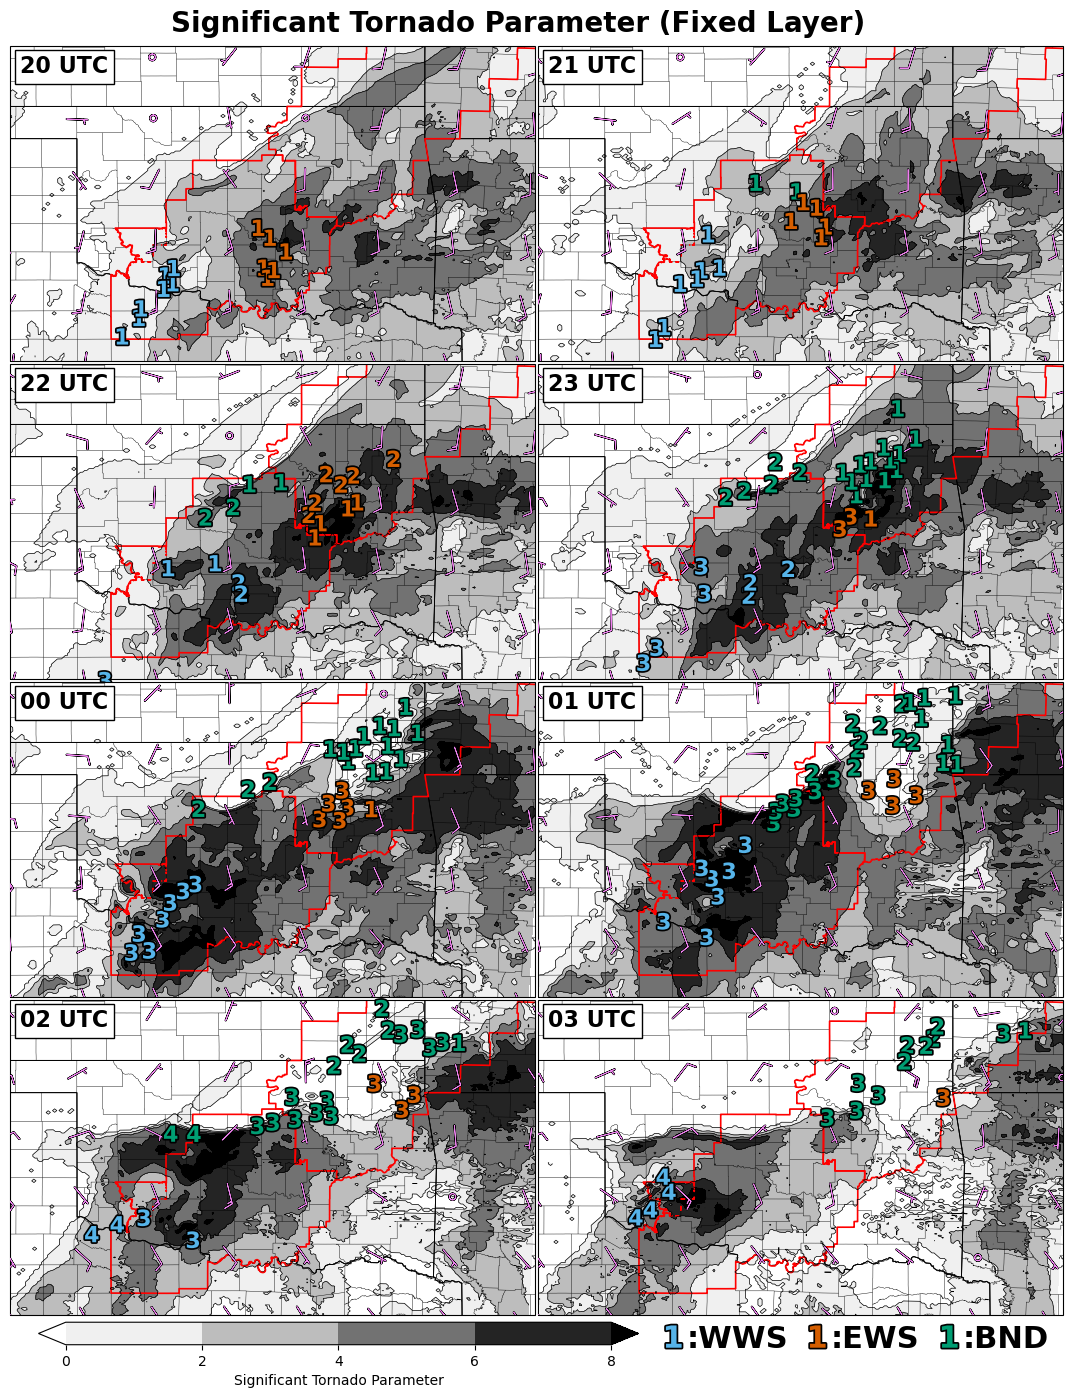

In [88]:

profile_df = pd.read_csv(r"D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\5_22_VerticalProfs_QC_Grouped_REVISED.csv")
current_hour = int(label.split()[0])  # "20 UTC" → 20
prof_subset = profile_df[profile_df['Time'] == current_hour]

# Load custom shapefiles
reader = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader_w = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = cfeature.ShapelyFeature(list(reader_w.geometries()), ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(list(reader_e.geometries()), ccrs.PlateCarree())

# RH file paths
rh_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_20\hr20_stp_fl.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_21\hr20_stp_fl.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_22\hr20_stp_fl.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_23\hr20_stp_fl.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_00\hr20_stp_fl.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_01\hr20_stp_fl.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_02\hr20_stp_fl.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_03\hr20_stp_fl.csv"
]

# Wind data (u and v components in knots)
u_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_u_SFC.csv"
]

v_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_v_SFC.csv"
]



# Hour labels for corner annotation
hour_labels = ["20 UTC", "21 UTC", "22 UTC", "23 UTC", "00 UTC", "01 UTC", "02 UTC", "03 UTC"]

# Set up figure
fig = plt.figure(figsize=(12, 15))
projection = ccrs.PlateCarree()

# Define domain extent
extent = [np.min(lon1)+0.2, np.max(lon1)-0.2, np.min(lat1)+0.1, np.max(lat1)-0.1]

barb_style = dict(path_effects=[withStroke(linewidth=1.5, foreground="white")])

# Manual subplot placement (2 columns x 4 rows)
ncols, nrows = 2, 4
panel_width = 0.45
panel_height = 0.21
left_margin = 0.07
bottom_margin = 0.09
hspace = 0.002
wspace = -0.01

for idx, (rh_file, label) in enumerate(zip(rh_files, hour_labels)):
    col = idx % ncols
    row = idx // ncols
    left = left_margin + col * (panel_width + wspace)
    bottom = bottom_margin + (nrows - 1 - row) * (panel_height + hspace)

    ax = fig.add_axes([left, bottom, panel_width, panel_height], projection=projection)
    ax.set_extent(extent)

    rh = np.loadtxt(rh_file, delimiter=',')
    u = np.loadtxt(u_files[idx], delimiter=',')* 1.94384
    v = np.loadtxt(v_files[idx], delimiter=',')* 1.94384
    #mesh = ax.pcolormesh(lon1, lat1, rh, cmap='Greys', shading='auto', vmin=0, vmax=90)
    
    levels = np.arange(0, 10, 2)  # define 10% spaced levels for contours

    # Filled contours
    mesh = ax.contourf(lon1, lat1, rh, levels=levels, cmap='Greys', extend='both', transform=ccrs.PlateCarree())

    # Line contours
    contours = ax.contour(lon1, lat1, rh, levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    #ax.clabel(contours, inline=True, fontsize=7, fmt='%d', colors='black')  # optional labels on lines

    stride = 35
    ax.barbs(
        lon1[::stride, ::stride], lat1[::stride, ::stride],
        u[::stride, ::stride], v[::stride, ::stride],
        length=5.5, linewidth=0.6, barbcolor='violet', pivot='middle', zorder=10,
        transform=ccrs.PlateCarree()
        ,path_effects=[withStroke(linewidth=1.5, foreground="black")]
    )

    # Map features
    ax.add_feature(cfeature.STATES, linewidth=0.6)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.3)
    ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=1.2)
    ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=1.2)

    # Time label
    ax.text(0.02, 0.97, label, transform=ax.transAxes,
            ha='left', va='top', fontsize=16, fontweight='bold',
            bbox=dict(facecolor='white', alpha=1.0, edgecolor='black'), zorder=11)
    
    current_hour = int(label.split()[0])  # Extracts 20 from "20 UTC"
    prof_subset = profile_df[profile_df['Time'] == current_hour]

    for _, prof_row in prof_subset.iterrows():
        group = prof_row['Grouping']
        lat = prof_row['Lat']
        lon = prof_row['Lon']

        if isinstance(group, str):
            # Set color based on prefix
            if group.startswith('OPW'):
                color = '#56B4E9'
            elif group.startswith('OPE'):
                color = '#D55E00'
            elif group.startswith('BDW') or group.startswith('BDE'):
                color = '#009E73'
            else:
                color = 'black'

            # Plot the numeric part of the group
            number = ''.join(filter(str.isdigit, group))
            if number:
                lon_adj = lon
                lat_adj = lat
                buffer_deg = 0.2
                
                if lon < extent[0] + buffer_deg:
                    lon_adj += buffer_deg
                elif lon > extent[1] - buffer_deg:
                    lon_adj -= buffer_deg

                if lat < extent[2] + buffer_deg:
                    lat_adj += buffer_deg
                elif lat > extent[3] - buffer_deg:
                    lat_adj -= buffer_deg
                
                txt = ax.text(
                    lon_adj, lat_adj, number, fontsize=16, fontweight='bold', color=color,
                    ha='center', va='center', transform=ccrs.PlateCarree(), zorder=12
                )
                txt.set_path_effects([
                    path_effects.Stroke(linewidth=2.5, foreground='black'),
                    path_effects.Normal()
                ])

# Manually placed colorbar
cax = fig.add_axes([0.10, 0.07, 0.5, 0.015])
cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', label='Significant Tornado Parameter')

outline = [path_effects.Stroke(linewidth=2.5, foreground='black'), path_effects.Normal()]

# Add the base text (group labels in black)
fig.text(0.64, 0.068, ":WWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.76, 0.068, ":EWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.87, 0.068, ":BND", fontsize=22, fontweight='bold', color='black')

# Overlay colored numbers with outlines
fig.text(0.62, 0.068, "1", fontsize=22, fontweight='bold', color='#56B4E9', path_effects=outline)    # OPW
fig.text(0.74, 0.068, "1", fontsize=22, fontweight='bold', color='#D55E00', path_effects=outline)  # OPE
fig.text(0.85, 0.068, "1", fontsize=22, fontweight='bold', color='#009E73', path_effects=outline)   # BDW/BDE

# Add centered main title
#fig.suptitle("Elevated Stable Layer Depth (2.5 K/km)", fontsize=20, fontweight="bold", y=0.96)
fig.suptitle(r"Significant Tornado Parameter (Fixed Layer)", fontsize=20, fontweight="bold", y=0.96)


plt.show()

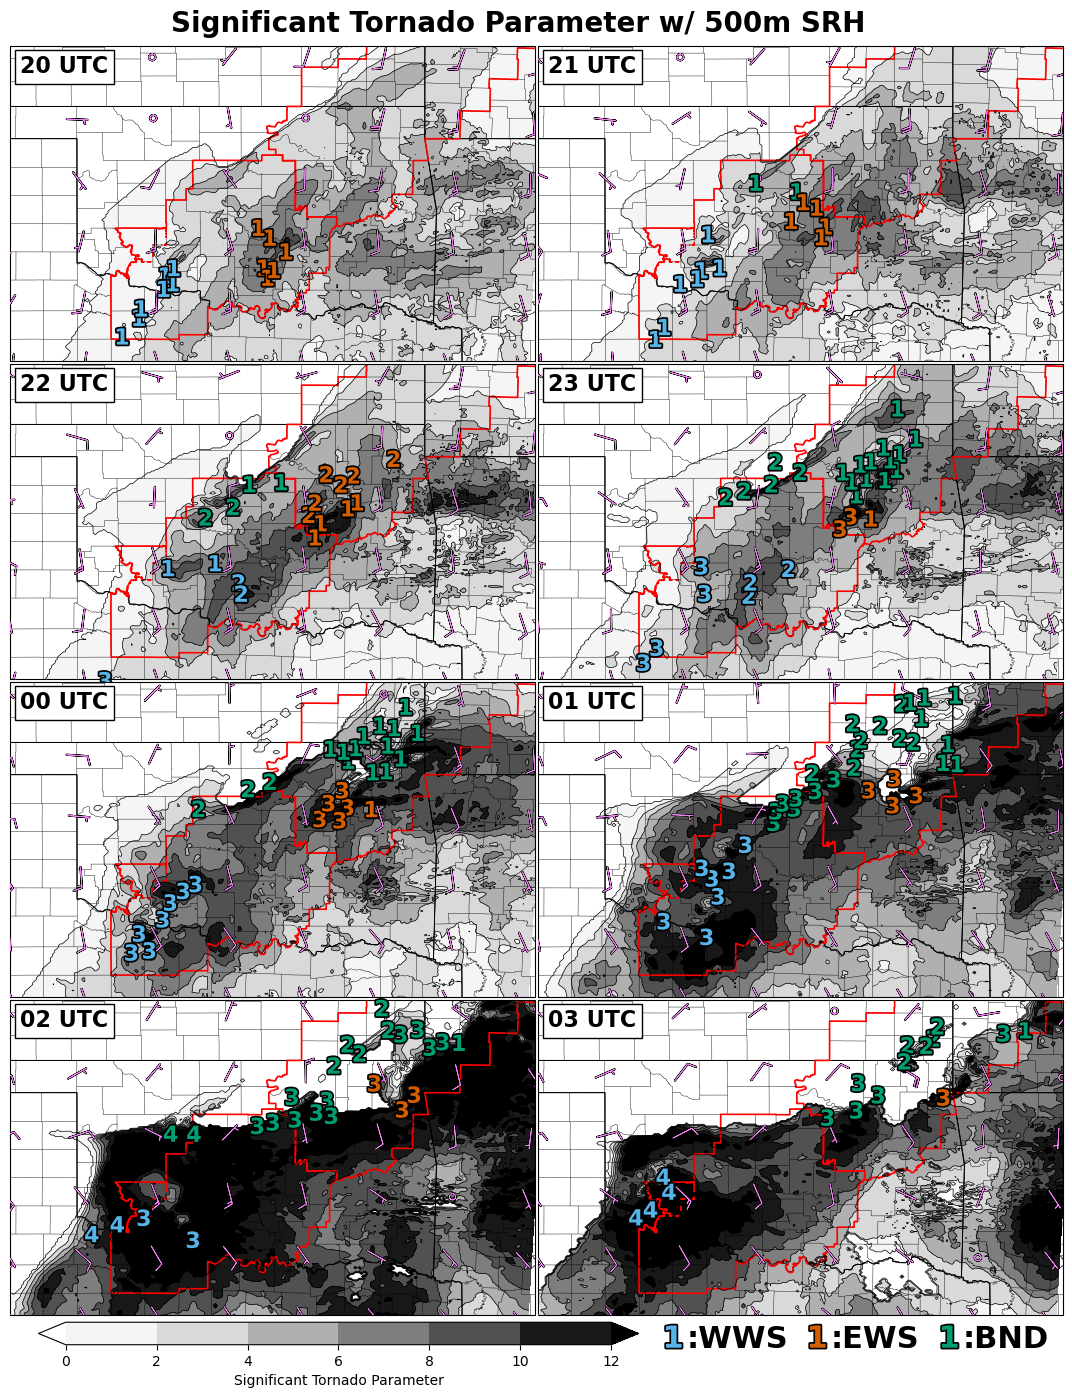

In [87]:

profile_df = pd.read_csv(r"D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\5_22_VerticalProfs_QC_Grouped_REVISED.csv")
current_hour = int(label.split()[0])  # "20 UTC" → 20
prof_subset = profile_df[profile_df['Time'] == current_hour]

# Load custom shapefiles
reader = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader_w = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = cfeature.ShapelyFeature(list(reader_w.geometries()), ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(list(reader_e.geometries()), ccrs.PlateCarree())

# RH file paths
rh_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_20\hr20_stp_500.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_21\hr20_stp_500.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_22\hr20_stp_500.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_23\hr20_stp_500.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_00\hr20_stp_500.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_01\hr20_stp_500.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_02\hr20_stp_500.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\Hourly_Array_03\hr20_stp_500.csv"
]

# Wind data (u and v components in knots)
u_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_u_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_u_SFC.csv"
]

v_files = [
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr20_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr21_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr22_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr23_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr0_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr1_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr2_v_SFC.csv",
    r"D:\THESIS\__UNL MS Thesis (MAIN)__\5 - Spatial Parameter Analysis\NEW_ARRAY\hr3_v_SFC.csv"
]



# Hour labels for corner annotation
hour_labels = ["20 UTC", "21 UTC", "22 UTC", "23 UTC", "00 UTC", "01 UTC", "02 UTC", "03 UTC"]

# Set up figure
fig = plt.figure(figsize=(12, 15))
projection = ccrs.PlateCarree()

# Define domain extent
extent = [np.min(lon1)+0.2, np.max(lon1)-0.2, np.min(lat1)+0.1, np.max(lat1)-0.1]

barb_style = dict(path_effects=[withStroke(linewidth=1.5, foreground="white")])

# Manual subplot placement (2 columns x 4 rows)
ncols, nrows = 2, 4
panel_width = 0.45
panel_height = 0.21
left_margin = 0.07
bottom_margin = 0.09
hspace = 0.002
wspace = -0.01

for idx, (rh_file, label) in enumerate(zip(rh_files, hour_labels)):
    col = idx % ncols
    row = idx // ncols
    left = left_margin + col * (panel_width + wspace)
    bottom = bottom_margin + (nrows - 1 - row) * (panel_height + hspace)

    ax = fig.add_axes([left, bottom, panel_width, panel_height], projection=projection)
    ax.set_extent(extent)

    rh = np.loadtxt(rh_file, delimiter=',')
    u = np.loadtxt(u_files[idx], delimiter=',')* 1.94384
    v = np.loadtxt(v_files[idx], delimiter=',')* 1.94384
    #mesh = ax.pcolormesh(lon1, lat1, rh, cmap='Greys', shading='auto', vmin=0, vmax=90)
    
    levels = np.arange(0, 14, 2)  # define 10% spaced levels for contours

    # Filled contours
    mesh = ax.contourf(lon1, lat1, rh, levels=levels, cmap='Greys', extend='both', transform=ccrs.PlateCarree())

    # Line contours
    contours = ax.contour(lon1, lat1, rh, levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    #ax.clabel(contours, inline=True, fontsize=7, fmt='%d', colors='black')  # optional labels on lines

    stride = 35
    ax.barbs(
        lon1[::stride, ::stride], lat1[::stride, ::stride],
        u[::stride, ::stride], v[::stride, ::stride],
        length=5.5, linewidth=0.6, barbcolor='violet', pivot='middle', zorder=10,
        transform=ccrs.PlateCarree()
        ,path_effects=[withStroke(linewidth=1.5, foreground="black")]
    )

    # Map features
    ax.add_feature(cfeature.STATES, linewidth=0.6)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.3)
    ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=1.2)
    ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=1.2)

    # Time label
    ax.text(0.02, 0.97, label, transform=ax.transAxes,
            ha='left', va='top', fontsize=16, fontweight='bold',
            bbox=dict(facecolor='white', alpha=1.0, edgecolor='black'), zorder=11)
    
    current_hour = int(label.split()[0])  # Extracts 20 from "20 UTC"
    prof_subset = profile_df[profile_df['Time'] == current_hour]

    for _, prof_row in prof_subset.iterrows():
        group = prof_row['Grouping']
        lat = prof_row['Lat']
        lon = prof_row['Lon']

        if isinstance(group, str):
            # Set color based on prefix
            if group.startswith('OPW'):
                color = '#56B4E9'
            elif group.startswith('OPE'):
                color = '#D55E00'
            elif group.startswith('BDW') or group.startswith('BDE'):
                color = '#009E73'
            else:
                color = 'black'

            # Plot the numeric part of the group
            number = ''.join(filter(str.isdigit, group))
            if number:
                lon_adj = lon
                lat_adj = lat
                buffer_deg = 0.2
                
                if lon < extent[0] + buffer_deg:
                    lon_adj += buffer_deg
                elif lon > extent[1] - buffer_deg:
                    lon_adj -= buffer_deg

                if lat < extent[2] + buffer_deg:
                    lat_adj += buffer_deg
                elif lat > extent[3] - buffer_deg:
                    lat_adj -= buffer_deg
                
                txt = ax.text(
                    lon_adj, lat_adj, number, fontsize=16, fontweight='bold', color=color,
                    ha='center', va='center', transform=ccrs.PlateCarree(), zorder=12
                )
                txt.set_path_effects([
                    path_effects.Stroke(linewidth=2.5, foreground='black'),
                    path_effects.Normal()
                ])

# Manually placed colorbar
cax = fig.add_axes([0.10, 0.07, 0.5, 0.015])
cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', label='Significant Tornado Parameter')

outline = [path_effects.Stroke(linewidth=2.5, foreground='black'), path_effects.Normal()]

# Add the base text (group labels in black)
fig.text(0.64, 0.068, ":WWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.76, 0.068, ":EWS", fontsize=22, fontweight='bold', color='black')
fig.text(0.87, 0.068, ":BND", fontsize=22, fontweight='bold', color='black')

# Overlay colored numbers with outlines
fig.text(0.62, 0.068, "1", fontsize=22, fontweight='bold', color='#56B4E9', path_effects=outline)    # OPW
fig.text(0.74, 0.068, "1", fontsize=22, fontweight='bold', color='#D55E00', path_effects=outline)  # OPE
fig.text(0.85, 0.068, "1", fontsize=22, fontweight='bold', color='#009E73', path_effects=outline)   # BDW/BDE

# Add centered main title
#fig.suptitle("Elevated Stable Layer Depth (2.5 K/km)", fontsize=20, fontweight="bold", y=0.96)
fig.suptitle(r"Significant Tornado Parameter w/ 500m SRH", fontsize=20, fontweight="bold", y=0.96)


plt.show()

# OLD CODE LOOP BELOW HERE:

In [83]:
xGRP5non = soundings[soundings.Time==k][soundings.Grouping=="OPW4"][soundings.Supercell=='N']
if len(xGRP5non) != 0:
    for i in range(0,len(xGRP5non)):
        if xGRP5non['Lon'].iloc[i] > -100.25 and xGRP5non['Lon'].iloc[i] < -94.0 and xGRP5non['Lat'].iloc[i] >33.0 and xGRP5non['Lat'].iloc[i] <37.25:
            plt.text(xGRP5non['Lon'].iloc[i],xGRP5non['Lat'].iloc[i],"OW",fontsize=52,fontweight='bold', color='lime')
xGRP5sup = soundings[soundings.Time==k][soundings.Grouping=="OPW4"][soundings.Supercell=='Y']
if len(xGRP5sup) != 0:
    for i in range(0,len(xGRP5sup)):
        if xGRP5sup['Lon'].iloc[i] > -100.25 and xGRP5sup['Lon'].iloc[i] < -94.0 and xGRP5sup['Lat'].iloc[i] >33.0 and xGRP5sup['Lat'].iloc[i] <37.25:
            plt.text(xGRP5sup['Lon'].iloc[i],xGRP5sup['Lat'].iloc[i],"OW*",fontsize=52,fontweight='bold', color='lime')

C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\4208394894.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP5non = soundings[soundings.Time==k][soundings.Grouping=="OPW4"][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\4208394894.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP5sup = soundings[soundings.Time==k][soundings.Grouping=="OPW4"][soundings.Supercell=='Y']


In [127]:
#for i in hours:
df1 = pd.read_csv(r"C:\Users\kyled\Desktop\CSV_Plot_Lists\Round2.csv")

k = 1
day0 = "23"

#for i in hours:
df1 = pd.read_csv(r"C:\Users\kyled\Desktop\CSV_Plot_Lists\Round2.csv")


#folder = r"C:\Users\kyled\Desktop\RAPout_Arrays\_"+str(i)
folder = r"C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_"+str(k)
files = glob.glob(folder+'\*.csv')
for j in range(22, 23):
    print(files[j])

for j in range(22, 23):
    print(df1['param'][j])

C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_1\hr01_dCAPE.csv
dCAPE


In [139]:
#for i in hours:
df1 = pd.read_csv(r"C:\Users\kyled\Desktop\CSV_Plot_Lists\Round2.csv")

k = 0
day0 = "23"

#folder = r"C:\Users\kyled\Desktop\RAPout_Arrays\_"+str(i)
folder = r"C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_"+str(k)
files = glob.glob(folder+'\*.csv')
#for j in range(0, len(files)):
for j in range(22, 23):

    df = pd.read_csv(files[j],header = None)
    df.fillna(0,inplace=True)
    data = df.to_numpy()
    
    df2=pd.read_csv(files[-2],header = None)
    df3=pd.read_csv(files[-1],header = None)
    df2.fillna(0,inplace=True)
    datadf2 = df2.to_numpy()
    df3.fillna(0,inplace=True)
    datadf3 = df3.to_numpy()
    
    fig=plt.figure(figsize = (36,36))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks([-180,-120,-60,0,60,120,180])
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
    ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
    ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
    ax.set_extent([-100.25, -94.0, 33.0, 37.25])

    #cf = ax.contour(lon, lat, data, levels = levels, cmap=cmap2) # Make a filled contour plot
    #cf1 = ax.contourf(lon, lat, data, levels = levels, cmap=cmap1) # Make a filled contour plot
    levels = np.arange(df1['lowBound'][j], df1['highBound'][j], df1['cf_levels'][j])
    
    if k <10:
        K = '0'+str(k)
    else:
        K=k
    
    if files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(k)+'\hr'+str(K)+'_Inhibition_0_mlCIN.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
        ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=7.5,linewidth=1.5, color='black')
        title = str(day0)+" May 2019, "+str(k)+"z \n" + df1['param'][j] +" and Surface Winds"

    
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(k)+'\hr'+str(K)+'_Inhibition_1_muCIN.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
        ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=7.5,linewidth=1.5, color='black')
        title = str(day0)+" May 2019, "+str(k)+"z \n" + df1['param'][j] +" and Surface Winds"


    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(k)+'\hr'+str(K)+'_Moisture_11_meanRH1_3kmAGL.csv'):
        cmap_1 = plt.get_cmap('binary')
        cmap_2 = plt.get_cmap('gray')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
        ax.barbs(x = lon[327:513,790:1040][::8,::8], y = lat[327:513,790:1040][::8,::8], u = datadf2[::8,::8], v = datadf3[::8,::8], length=7.5,linewidth=1.5, color='black')
        title = str(day0)+" May 2019, "+str(k)+"z \n" + df1['param'][j] +" and 700 hPa Winds"
        
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(k)+'\hr'+str(K)+'_t_700.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
        wind_spd = wind_speed(datadf2*units('knot'), datadf3*units('knot'))
        cf_wind = ax.contour(lon1, lat1, wind_spd, levels=np.arange(0,20,5),cmap='Blues', linewidths = 6)
        ax.clabel(cf_wind, fontsize=39, inline=True)
        ax.barbs(x = lon[327:513,790:1040][::8,::8], y = lat[327:513,790:1040][::8,::8], u = datadf2[::8,::8], v = datadf3[::8,::8], length=7.5,linewidth=1.5, color='black')
        title = str(day0)+" May 2019, "+str(k)+"z \n 700 hPa Temperature and Winds"
        
    else:
        cmap_1 = plt.get_cmap('binary')
        cmap_2 = plt.get_cmap('gray')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
        ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=7.5,linewidth=1.5, color='black')
        title = str(day0)+" May 2019, "+str(k)+"z \n" + df1['param'][j] +" and Surface Winds"
        
    ax.set_title(title, fontsize=45, fontweight='bold')

    #cf = ax.contour(lon1, lat1, data, 10, cmap=cmap2) # Make a filled contour plot
    #cf1 = ax.contourf(lon1, lat1, data, 10, cmap=cmap1) # Make a filled contour plot
    
    ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=7.5,linewidth=1.5, color='black')

    cbar = plt.colorbar(cf1, extend='both', shrink=0.55, pad=0.01)
    cbar.ax.tick_params(labelsize=20)

    soundings = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs_QC_Grouped.csv', usecols=['Time','Grouping', 'Lat', 'Lon','Supercell'])
    xGRP1non = soundings[soundings.Time==k][soundings.Grouping=="OPW1"][soundings.Supercell=='N']
    if len(xGRP1non) != 0:
        for i in range(0,len(xGRP1non)):
            if xGRP1non['Lon'].iloc[i] > -100.25 and xGRP1non['Lon'].iloc[i] < -94.0 and xGRP1non['Lat'].iloc[i] >33.0 and xGRP1non['Lat'].iloc[i] <37.1:
                plt.text(xGRP1non['Lon'].iloc[i],xGRP1non['Lat'].iloc[i],"OW",fontsize=52,fontweight='bold', color='lime')
    xGRP1sup = soundings[soundings.Time==k][soundings.Grouping==1][soundings.Supercell=='Y']
    if len(xGRP1sup) != 0:
        for i in range(0,len(xGRP1sup)):
            if xGRP1sup['Lon'].iloc[i] > -100.25 and xGRP1sup['Lon'].iloc[i] < -94.0 and xGRP1sup['Lat'].iloc[i] >33.0 and xGRP1sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP1sup['Lon'].iloc[i],xGRP1sup['Lat'].iloc[i],"OW*",fontsize=52,fontweight='bold', color='lime')      

    xGRP2non = soundings[soundings.Time==k][soundings.Grouping=="OPW2"][soundings.Supercell=='N']
    if len(xGRP2non) != 0:
        for i in range(0,len(xGRP2non)):
            if xGRP2non['Lon'].iloc[i] > -100.25 and xGRP2non['Lon'].iloc[i] < -94.0 and xGRP2non['Lat'].iloc[i] >33.0 and xGRP2non['Lat'].iloc[i] <37.1:
                plt.text(xGRP2non['Lon'].iloc[i],xGRP2non['Lat'].iloc[i],'OW',fontsize=52,fontweight='bold', color='lime')
    xGRP2sup = soundings[soundings.Time==k][soundings.Grouping=="OPW2"][soundings.Supercell=='Y']
    if len(xGRP2sup) != 0:
        for i in range(0,len(xGRP2sup)):
            if xGRP2sup['Lon'].iloc[i] > -100.25 and xGRP2sup['Lon'].iloc[i] < -94.0 and xGRP2sup['Lat'].iloc[i] >33.0 and xGRP2sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP2sup['Lon'].iloc[i],xGRP2sup['Lat'].iloc[i],'OW*',fontsize=52,fontweight='bold', color='lime')

    xGRP4non = soundings[soundings.Time==k][soundings.Grouping=="OPW3"][soundings.Supercell=='N']
    if len(xGRP4non) != 0:
        for i in range(0,len(xGRP4non)):
            if xGRP4non['Lon'].iloc[i] > -100.25 and xGRP4non['Lon'].iloc[i] < -94.0 and xGRP4non['Lat'].iloc[i] >33.0 and xGRP4non['Lat'].iloc[i] <37.1:
                plt.text(xGRP4non['Lon'].iloc[i],xGRP4non['Lat'].iloc[i],"OW",fontsize=52,fontweight='bold', color='lime')
    xGRP4sup = soundings[soundings.Time==k][soundings.Grouping=="OPW3"][soundings.Supercell=='Y']
    if len(xGRP4sup) != 0:
        for i in range(0,len(xGRP4sup)):
            if xGRP4sup['Lon'].iloc[i] > -100.25 and xGRP4sup['Lon'].iloc[i] < -94.0 and xGRP4sup['Lat'].iloc[i] >33.0 and xGRP4sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP4sup['Lon'].iloc[i],xGRP4sup['Lat'].iloc[i],"OW*",fontsize=52,fontweight='bold', color='lime')

    xGRP5non = soundings[soundings.Time==k][soundings.Grouping=="OPW4"][soundings.Supercell=='N']
    if len(xGRP5non) != 0:
        for i in range(0,len(xGRP5non)):
            if xGRP5non['Lon'].iloc[i] > -100.25 and xGRP5non['Lon'].iloc[i] < -94.0 and xGRP5non['Lat'].iloc[i] >33.0 and xGRP5non['Lat'].iloc[i] <37.1:
                plt.text(xGRP5non['Lon'].iloc[i],xGRP5non['Lat'].iloc[i],"OW",fontsize=52,fontweight='bold', color='lime')
    xGRP5sup = soundings[soundings.Time==k][soundings.Grouping=="OPW4"][soundings.Supercell=='Y']
    if len(xGRP5sup) != 0:
        for i in range(0,len(xGRP5sup)):
            if xGRP5sup['Lon'].iloc[i] > -100.25 and xGRP5sup['Lon'].iloc[i] < -94.0 and xGRP5sup['Lat'].iloc[i] >33.0 and xGRP5sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP5sup['Lon'].iloc[i],xGRP5sup['Lat'].iloc[i],"OW*",fontsize=52,fontweight='bold', color='lime')

    xGRP7non = soundings[soundings.Time==k][soundings.Grouping=="OPE1"][soundings.Supercell=='N']
    if len(xGRP7non) != 0:
        for i in range(0,len(xGRP7non)):
            if xGRP7non['Lon'].iloc[i] > -100.25 and xGRP7non['Lon'].iloc[i] < -94.0 and xGRP7non['Lat'].iloc[i] >33.0 and xGRP7non['Lat'].iloc[i] <37.1:
                plt.text(xGRP7non['Lon'].iloc[i],xGRP7non['Lat'].iloc[i],"OE",fontsize=52,fontweight='bold', color='fuchsia')
    xGRP7sup = soundings[soundings.Time==k][soundings.Grouping=="OPE1"][soundings.Supercell=='Y']
    if len(xGRP7sup) != 0:
        for i in range(0,len(xGRP7sup)):
            if xGRP7sup['Lon'].iloc[i] > -100.25 and xGRP7sup['Lon'].iloc[i] < -94.0 and xGRP7sup['Lat'].iloc[i] >33.0 and xGRP7sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP7sup['Lon'].iloc[i],xGRP7sup['Lat'].iloc[i],"OE*",fontsize=52,fontweight='bold', color='fuchsia')

    xGRP8non = soundings[soundings.Time==k][soundings.Grouping=="OPE2"][soundings.Supercell=='N']
    if len(xGRP8non) != 0:
        for i in range(0,len(xGRP8non)):
            if xGRP8non['Lon'].iloc[i] > -100.25 and xGRP8non['Lon'].iloc[i] < -94.0 and xGRP8non['Lat'].iloc[i] >33.0 and xGRP8non['Lat'].iloc[i] <37.1:
                plt.text(xGRP8non['Lon'].iloc[i],xGRP8non['Lat'].iloc[i],"OE",fontsize=52,fontweight='bold', color='fuchsia')
    xGRP8sup = soundings[soundings.Time==k][soundings.Grouping=="OPE2"][soundings.Supercell=='Y']
    if len(xGRP8sup) != 0:
        for i in range(0,len(xGRP8sup)):
            if xGRP8sup['Lon'].iloc[i] > -100.25 and xGRP8sup['Lon'].iloc[i] < -94.0 and xGRP8sup['Lat'].iloc[i] >33.0 and xGRP8sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP8sup['Lon'].iloc[i],xGRP8sup['Lat'].iloc[i],"OE*",fontsize=52,fontweight='bold', color='fuchsia')

    xGRP9non = soundings[soundings.Time==k][soundings.Grouping=="OPE3"][soundings.Supercell=='N']
    if len(xGRP9non) != 0:
        for i in range(0,len(xGRP9non)):
            if xGRP9non['Lon'].iloc[i] > -100.25 and xGRP9non['Lon'].iloc[i] < -94.0 and xGRP9non['Lat'].iloc[i] >33.0 and xGRP9non['Lat'].iloc[i] <37.1:
                plt.text(xGRP9non['Lon'].iloc[i],xGRP9non['Lat'].iloc[i],"OE",fontsize=52,fontweight='bold', color='fuchsia')
    xGRP9sup = soundings[soundings.Time==k][soundings.Grouping=="OPE3"][soundings.Supercell=='Y']
    if len(xGRP9sup) != 0:
        for i in range(0,len(xGRP9sup)):
            if xGRP9sup['Lon'].iloc[i] > -100.25 and xGRP9sup['Lon'].iloc[i] < -94.0 and xGRP9sup['Lat'].iloc[i] >33.0 and xGRP9sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP9sup['Lon'].iloc[i],xGRP9sup['Lat'].iloc[i],"OE*",fontsize=52,fontweight='bold', color='fuchsia')

    xGRP11non = soundings[soundings.Time==k][soundings.Grouping=="BDW1"][soundings.Supercell=='N']
    if len(xGRP11non) != 0:
        for i in range(0,len(xGRP11non)):
            if xGRP11non['Lon'].iloc[i] > -100.25 and xGRP11non['Lon'].iloc[i] < -94.0 and xGRP11non['Lat'].iloc[i] >33.0 and xGRP11non['Lat'].iloc[i] <37.1:
                plt.text(xGRP11non['Lon'].iloc[i],xGRP11non['Lat'].iloc[i],"BW",fontsize=52,fontweight='bold', color='cyan')
    xGRP11sup = soundings[soundings.Time==k][soundings.Grouping=="BDW1"][soundings.Supercell=='Y']
    if len(xGRP11sup) != 0:
        for i in range(0,len(xGRP11sup)):
            if xGRP11sup['Lon'].iloc[i] > -100.25 and xGRP11sup['Lon'].iloc[i] < -94.0 and xGRP11sup['Lat'].iloc[i] >33.0 and xGRP11sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP11sup['Lon'].iloc[i],xGRP11sup['Lat'].iloc[i],"BW*",fontsize=52,fontweight='bold', color='cyan')

    xGRP12non = soundings[soundings.Time==k][soundings.Grouping=="BDW2"][soundings.Supercell=='N']
    if len(xGRP12non) != 0:
        for i in range(0,len(xGRP12non)):
            if xGRP12non['Lon'].iloc[i] > -100.25 and xGRP12non['Lon'].iloc[i] < -94.0 and xGRP12non['Lat'].iloc[i] >33.0 and xGRP12non['Lat'].iloc[i] <37.1:
                plt.text(xGRP12non['Lon'].iloc[i],xGRP12non['Lat'].iloc[i],"BW",fontsize=52,fontweight='bold', color='cyan')
    xGRP12sup = soundings[soundings.Time==k][soundings.Grouping=="BDW2"][soundings.Supercell=='Y']
    if len(xGRP12sup) != 0:
        for i in range(0,len(xGRP12sup)):
            if xGRP12sup['Lon'].iloc[i] > -100.25 and xGRP12sup['Lon'].iloc[i] < -94.0 and xGRP12sup['Lat'].iloc[i] >33.0 and xGRP12sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP12sup['Lon'].iloc[i],xGRP12sup['Lat'].iloc[i],"BW*",fontsize=52,fontweight='bold', color='cyan')

    xGRP13non = soundings[soundings.Time==k][soundings.Grouping=="BDW3"][soundings.Supercell=='N']
    if len(xGRP13non) != 0:
        for i in range(0,len(xGRP13non)):
            if xGRP13non['Lon'].iloc[i] > -100.25 and xGRP13non['Lon'].iloc[i] < -94.0 and xGRP13non['Lat'].iloc[i] >33.0 and xGRP13non['Lat'].iloc[i] <37.1:
                plt.text(xGRP13non['Lon'].iloc[i],xGRP13non['Lat'].iloc[i],"BW",fontsize=52,fontweight='bold', color='cyan')
    xGRP13sup = soundings[soundings.Time==k][soundings.Grouping=="BDW3"][soundings.Supercell=='Y']
    if len(xGRP13sup) != 0:
        for i in range(0,len(xGRP13sup)):
            if xGRP13sup['Lon'].iloc[i] > -100.25 and xGRP13sup['Lon'].iloc[i] < -94.0 and xGRP13sup['Lat'].iloc[i] >33.0 and xGRP13sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP13sup['Lon'].iloc[i],xGRP13sup['Lat'].iloc[i],"BW*",fontsize=52,fontweight='bold', color='cyan')

    xGRP14non = soundings[soundings.Time==k][soundings.Grouping=="BDW4"][soundings.Supercell=='N']
    if len(xGRP14non) != 0:
        for i in range(0,len(xGRP14non)):
            if xGRP14non['Lon'].iloc[i] > -100.25 and xGRP14non['Lon'].iloc[i] < -94.0 and xGRP14non['Lat'].iloc[i] >33.0 and xGRP14non['Lat'].iloc[i] <37.1:
                plt.text(xGRP14non['Lon'].iloc[i],xGRP14non['Lat'].iloc[i],"BW",fontsize=52,fontweight='bold', color='cyan')
    xGRP14sup = soundings[soundings.Time==k][soundings.Grouping=="BDW4"][soundings.Supercell=='Y']
    if len(xGRP14sup) != 0:
        for i in range(0,len(xGRP14sup)):
            if xGRP14sup['Lon'].iloc[i] > -100.25 and xGRP14sup['Lon'].iloc[i] < -94.0 and xGRP14sup['Lat'].iloc[i] >33.0 and xGRP14sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP14sup['Lon'].iloc[i],xGRP14sup['Lat'].iloc[i],"BW*",fontsize=52,fontweight='bold', color='cyan')

    xGRP15non = soundings[soundings.Time==k][soundings.Grouping=="BDE1"][soundings.Supercell=='N']
    if len(xGRP15non) != 0:
        for i in range(0,len(xGRP15non)):
            if xGRP15non['Lon'].iloc[i] > -100.25 and xGRP15non['Lon'].iloc[i] < -94.0 and xGRP15non['Lat'].iloc[i] >33.0 and xGRP15non['Lat'].iloc[i] <37.1:
                plt.text(xGRP15non['Lon'].iloc[i],xGRP15non['Lat'].iloc[i],"BE",fontsize=52,fontweight='bold', color='orange')
    xGRP15sup = soundings[soundings.Time==k][soundings.Grouping=="BDE1"][soundings.Supercell=='Y']
    if len(xGRP15sup) != 0:
        for i in range(0,len(xGRP15sup)):
            if xGRP15sup['Lon'].iloc[i] > -100.25 and xGRP15sup['Lon'].iloc[i] < -94.0 and xGRP15sup['Lat'].iloc[i] >33.0 and xGRP15sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP15sup['Lon'].iloc[i],xGRP15sup['Lat'].iloc[i],"BE*",fontsize=52,fontweight='bold', color='orange')

    xGRP16non = soundings[soundings.Time==k][soundings.Grouping=="BDE2"][soundings.Supercell=='N']
    if len(xGRP16non) != 0:
        for i in range(0,len(xGRP16non)):
            if xGRP16non['Lon'].iloc[i] > -100.25 and xGRP16non['Lon'].iloc[i] < -94.0 and xGRP16non['Lat'].iloc[i] >33.0 and xGRP16non['Lat'].iloc[i] <37.1:
                plt.text(xGRP16non['Lon'].iloc[i],xGRP16non['Lat'].iloc[i],"BE",fontsize=52,fontweight='bold', color='orange')
    xGRP16sup = soundings[soundings.Time==k][soundings.Grouping=="BDE2"][soundings.Supercell=='Y']
    if len(xGRP16sup) != 0:
        for i in range(0,len(xGRP16sup)):
            if xGRP16sup['Lon'].iloc[i] > -100.25 and xGRP16sup['Lon'].iloc[i] < -94.0 and xGRP16sup['Lat'].iloc[i] >33.0 and xGRP16sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP16sup['Lon'].iloc[i],xGRP16sup['Lat'].iloc[i],"BE*",fontsize=52,fontweight='bold', color='orange')


    xGRP17non = soundings[soundings.Time==k][soundings.Grouping=="BDE3"][soundings.Supercell=='N']
    if len(xGRP17non) != 0:
        for i in range(0,len(xGRP17non)):
            if xGRP17non['Lon'].iloc[i] > -100.25 and xGRP17non['Lon'].iloc[i] < -94.0 and xGRP17non['Lat'].iloc[i] >33.0 and xGRP17non['Lat'].iloc[i] <37.1:
                plt.text(xGRP17non['Lon'].iloc[i],xGRP17non['Lat'].iloc[i],"BE",fontsize=52,fontweight='bold', color='orange')
    xGRP17sup = soundings[soundings.Time==k][soundings.Grouping=="BDE3"][soundings.Supercell=='Y']
    if len(xGRP17sup) != 0:
        for i in range(0,len(xGRP17sup)):
            if xGRP17sup['Lon'].iloc[i] > -100.25 and xGRP17sup['Lon'].iloc[i] < -94.0 and xGRP17sup['Lat'].iloc[i] >33.0 and xGRP17sup['Lat'].iloc[i] <37.1:
                plt.text(xGRP17sup['Lon'].iloc[i],xGRP17sup['Lat'].iloc[i],"BE*",fontsize=52,fontweight='bold', color='orange')

    fig.set_facecolor('whitesmoke')
    #plt.legend(loc='upper left', fontsize = 35,shadow=True)
    #fig.tight_layout()
    #plt.savefig(r"C:/Users/kyled/Desktop/HRRROuts/MAPS2/"+str(k)+"/"+str(df1['Category'][j])+"_"+str(df1['param'][j])+"_"+str(k)+".png", bbox_inches='tight')
    #plt.savefig(r"C:/Users/kyled/Desktop/HRRROuts/0z/"+str(df1['Category'][j])+"_"+str(df1['param'][j])+"_"+str(k)+".png", bbox_inches='tight')
    plt.show()
    #plt.close(fig)
    #plt.clf()

    print(df1['param'][j], k, j)
    j+=1

C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\1145800794.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==k][soundings.Grouping=="OPW1"][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\1145800794.py:114: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==k][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\1145800794.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==k][soundings.Grouping=="OPW2"][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\1145800794.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==k][soundings.Grouping=="OPW2"][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykern

dCAPE 0 22


<Figure size 640x480 with 0 Axes>

In [24]:
#for i in hours:
df1 = pd.read_csv(r"C:\Users\kyled\Desktop\CSV_Plot_Lists\Round2.csv")

i = 22
day0 = "22"

#folder = r"C:\Users\kyled\Desktop\RAPout_Arrays\_"+str(i)
folder = r"C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_"+str(i)
files = glob.glob(folder+'\*.csv')
for j in range(0, len(files)):

    df = pd.read_csv(files[j],header = None)
    df.fillna(0,inplace=True)
    data = df.to_numpy()
    title = str(day0)+" May 2019, "+str(i)+"z \n" + df1['param'][j] +" and Surface Winds"
    fig=plt.figure(figsize = (36,36))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(title, fontsize=45, fontweight='bold')
    ax.set_xticks([-180,-120,-60,0,60,120,180])
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
    ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
    ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
    ax.set_extent([-100.25, -94.0, 33.0, 37.25])

    #cf = ax.contour(lon, lat, data, levels = levels, cmap=cmap2) # Make a filled contour plot
    #cf1 = ax.contourf(lon, lat, data, levels = levels, cmap=cmap1) # Make a filled contour plot
    levels = np.arange(df1['lowBound'][j], df1['highBound'][j], df1['cf_levels'][j])
    if files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_Inhibition_0_mlCIN.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_Inhibition_1_muCIN.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
    else:
        cmap_1 = plt.get_cmap('binary')
        cmap_2 = plt.get_cmap('gray')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot

    #cf = ax.contour(lon1, lat1, data, 10, cmap=cmap2) # Make a filled contour plot
    #cf1 = ax.contourf(lon1, lat1, data, 10, cmap=cmap1) # Make a filled contour plot
    
    ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=7.5,linewidth=1.5, color='black')

    cbar = plt.colorbar(cf1, extend='both', shrink=0.55, pad=0.01)
    cbar.ax.tick_params(labelsize=20)

    soundings = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs_QC.csv', usecols=['Time','Grouping', 'Lat', 'Lon','Supercell'])
    xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
    if len(xGRP1non) != 0:
        for k in range(0,len(xGRP1non)):
            plt.text(xGRP1non['Lon'].iloc[k],xGRP1non['Lat'].iloc[k],'1',fontsize=52,fontweight='bold', color='lime')
    xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
    if len(xGRP1sup) != 0:
        for k in range(0,len(xGRP1sup)):
            plt.text(xGRP1sup['Lon'].iloc[k],xGRP1sup['Lat'].iloc[k],'1*',fontsize=64,fontweight='bold', color='lime')      

    xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
    if len(xGRP2non) != 0:
        for k in range(0,len(xGRP2non)):
            plt.text(xGRP2non['Lon'].iloc[k],xGRP2non['Lat'].iloc[k],'2',fontsize=52,fontweight='bold', color='fuchsia')
    xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
    if len(xGRP2sup) != 0:
        for k in range(0,len(xGRP2sup)):
            plt.text(xGRP2sup['Lon'].iloc[k],xGRP2sup['Lat'].iloc[k],'2*',fontsize=64,fontweight='bold', color='fuchsia')

    xGRP4non = soundings[soundings.Time==i][soundings.Grouping==4][soundings.Supercell=='N']
    if len(xGRP4non) != 0:
        for k in range(0,len(xGRP4non)):
            plt.text(xGRP4non['Lon'].iloc[k],xGRP4non['Lat'].iloc[k],'4',fontsize=52,fontweight='bold', color='lime')
    xGRP4sup = soundings[soundings.Time==i][soundings.Grouping==4][soundings.Supercell=='Y']
    if len(xGRP4sup) != 0:
        for k in range(0,len(xGRP4sup)):
            plt.text(xGRP4sup['Lon'].iloc[k],xGRP4sup['Lat'].iloc[k],'4*',fontsize=64,fontweight='bold', color='lime')

    xGRP5non = soundings[soundings.Time==i][soundings.Grouping==5][soundings.Supercell=='N']
    if len(xGRP5non) != 0:
        for k in range(0,len(xGRP5non)):
            plt.text(xGRP5non['Lon'].iloc[k],xGRP5non['Lat'].iloc[k],'5',fontsize=52,fontweight='bold', color='lime')
    xGRP5sup = soundings[soundings.Time==i][soundings.Grouping==5][soundings.Supercell=='Y']
    if len(xGRP5sup) != 0:
        for k in range(0,len(xGRP5sup)):
            plt.text(xGRP5sup['Lon'].iloc[k],xGRP5sup['Lat'].iloc[k],'5*',fontsize=64,fontweight='bold', color='lime')

    #xGRP7non = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='N']
    #if len(xGRP7non) != 0:
    #    for k in range(0,len(xGRP7non)):
    #        plt.text(xGRP7non['Lon'].iloc[k],xGRP7non['Lat'].iloc[k],'7',fontsize=52,fontweight='bold', color='red')
    #xGRP7sup = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='Y']
    #if len(xGRP7sup) != 0:
    #    for k in range(0,len(xGRP7sup)):
    #        plt.text(xGRP7sup['Lon'].iloc[k],xGRP7sup['Lat'].iloc[k],'7*',fontsize=52,fontweight='bold', color='red')

    xGRP8non = soundings[soundings.Time==i][soundings.Grouping==8][soundings.Supercell=='N']
    if len(xGRP8non) != 0:
        for k in range(0,len(xGRP8non)):
            plt.text(xGRP8non['Lon'].iloc[k],xGRP8non['Lat'].iloc[k],'8',fontsize=52,fontweight='bold', color='fuchsia')
    xGRP8sup = soundings[soundings.Time==i][soundings.Grouping==8][soundings.Supercell=='Y']
    if len(xGRP8sup) != 0:
        for k in range(0,len(xGRP8sup)):
            plt.text(xGRP8sup['Lon'].iloc[k],xGRP8sup['Lat'].iloc[k],'8*',fontsize=64,fontweight='bold', color='fuchsia')

    xGRP9non = soundings[soundings.Time==i][soundings.Grouping==9][soundings.Supercell=='N']
    if len(xGRP9non) != 0:
        for k in range(0,len(xGRP9non)):
            plt.text(xGRP9non['Lon'].iloc[k],xGRP9non['Lat'].iloc[k],'9',fontsize=52,fontweight='bold', color='fuchsia')
    xGRP9sup = soundings[soundings.Time==i][soundings.Grouping==9][soundings.Supercell=='Y']
    if len(xGRP9sup) != 0:
        for k in range(0,len(xGRP9sup)):
            plt.text(xGRP9sup['Lon'].iloc[k],xGRP9sup['Lat'].iloc[k],'9*',fontsize=64,fontweight='bold', color='fuchsia')

    xGRP11non = soundings[soundings.Time==i][soundings.Grouping==11][soundings.Supercell=='N']
    if len(xGRP11non) != 0:
        for k in range(0,len(xGRP11non)):
            plt.text(xGRP11non['Lon'].iloc[k],xGRP11non['Lat'].iloc[k],'11',fontsize=52,fontweight='bold', color='lime')
    xGRP11sup = soundings[soundings.Time==i][soundings.Grouping==11][soundings.Supercell=='Y']
    if len(xGRP11sup) != 0:
        for k in range(0,len(xGRP11sup)):
            plt.text(xGRP11sup['Lon'].iloc[k],xGRP11sup['Lat'].iloc[k],'11*',fontsize=64,fontweight='bold', color='lime')

    fig.set_facecolor('whitesmoke')
    plt.legend(loc='upper left', fontsize = 35,shadow=True)
    #fig.tight_layout()
    plt.savefig(r"C:/Users/kyled/Desktop/HRRROuts/MAPS/"+str(i)+"/"+str(df1['Category'][j])+"_"+str(df1['param'][j])+"_"+str(i)+".png", bbox_inches='tight')
    #plt.show()
    plt.close(fig)
    plt.clf()

    print(df1['param'][j], i, j)
    j+=1

C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlCAPE 22 0


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muCAPE 22 1


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

ml3CAPE 22 2


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

ml6CAPE 22 3


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

ml_LCLCAPE 22 4


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mu_LCLCAPE 22 5


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlSCP 22 6


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muSCP 22 7


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

ml_STP 22 8


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mu_STP 22 9


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

ml_STP_cin 22 10


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mu_STP_cin 22 11


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlSCshear 22 12


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muSCshear 22 13


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

sfc500mSRH 22 14


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

sfc1kmSRH 22 15


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

sfc3kmSRH 22 16


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlCIN 22 17


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muCIN 22 18


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

sfc1kmLapse 22 19


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlACBLlapse 22 20


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muACBLlapse 22 21


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlMAXomegaH 22 22


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlLCL_LFCdiff 22 23


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muLCL_LFCdiff 22 24


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

PBLtop 22 25


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muMAXomegaH 22 26


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlHLFC 22 27


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muHLFC 22 28


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlDeltaZstar 22 29


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlLCL 22 30


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muLCL 22 31


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlLFC 22 32


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muLFC 22 33


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlMRD 22 34


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mumeanRHLCL_LFC 22 35


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRH1_3kmAGL 22 36


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQ1kmAGL 22 37


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQ150_300mbAGL 22 38


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQpbl 22 39


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlmeanQLCL_LFC 22 40


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mumeanQLCL_LFC 22 41


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQ1_3kmAGL 22 42


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

muMRD 22 43


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQmlACBL 22 44


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQmuACBL 22 45


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRHmlACBL 22 46


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRHmuACBL 22 47


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanTEmlACBL 22 48


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanTEmuACBL 22 49


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRHml_LCL2k 22 50


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanTEml_LCL2k 22 51


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQml_LCL2k 22 52


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRHmu_LCL2k 22 53


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQ100mbAGL 22 54


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanTEmu_LCL2k 22 55


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanQmu_LCL2k 22 56


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRH1kmAGL 22 57


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRH150mbAGL 22 58


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRH150_300mbAGL 22 59


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanRHpbl 22 60


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlmeanRHLCL_LFC 22 61


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

bunkersRM 22 62


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

bunkersRMangle 22 63


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanSWpercvalue_3km 22 64


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanShearValue_500m 22 65


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanSWvalue_500m 22 66


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanSWpercvalue_500m 22 67


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanShearValue_1km 22 68


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanSWvalue_1km 22 69


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanSWpercvalue_1km 22 70


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanShearValue_3km 22 71


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

MeanSWvalue_3km 22 72


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mu_LCL_EL_Srflow 22 73


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

0_1kmSRflow 22 74


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

0_2kmSRflow 22 75


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

ml_LCL_EL_Srflow 22 76


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanTE100mb 22 77


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanThetaE1km 22 78


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanThetaEpbl 22 79


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanThetaE150mb 22 80


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanThetaE150_300mb 22 81


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mlmeanThetaE_LCL_LFC 22 82


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

mumeanThetaE_LCL_LFC 22 83


C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_18676\1630825988

meanThetaE1_3km 22 84


<Figure size 640x480 with 0 Axes>

In [97]:
#uwnd[0][::8,::8]
#vwnd[0][::8,::8]
##uwnd[:][::8,::8].shape
print(np.max(hgt[0][327:513,790:1040]), np.min(lev[0][327:513,790:1040]))
print(np.min(hgt[0][327:513,790:1040]), np.max(lev[0][327:513,790:1040]),"\n")

print(np.max(hgt[1][327:513,790:1040]))
print(np.min(hgt[1][327:513,790:1040]), "\n")

print(np.max(hgt[2][327:513,790:1040]), np.min(lev[2][327:513,790:1040]))
print(np.min(hgt[2][327:513,790:1040]), np.max(lev[2][327:513,790:1040]),"\n")

print(np.max(hgt[3][327:513,790:1040]))
print(np.min(hgt[3][327:513,790:1040]), "\n")

print(np.max(hgt[4][327:513,790:1040]), np.min(lev[4][327:513,790:1040]))
print(np.min(hgt[4][327:513,790:1040]), np.max(lev[4][327:513,790:1040]),"\n")

print(np.max(hgt[5][327:513,790:1040]))
print(np.min(hgt[5][327:513,790:1040]), "\n")

print(np.max(hgt[6][327:513,790:1040]), np.min(lev[6][327:513,790:1040]))
print(np.min(hgt[6][327:513,790:1040]), np.max(lev[6][327:513,790:1040]),"\n")

print(np.max(hgt[7][327:513,790:1040]))
print(np.min(hgt[7][327:513,790:1040]), "\n")

print(np.max(hgt[8][327:513,790:1040]), np.min(lev[8][327:513,790:1040]))
print(np.min(hgt[8][327:513,790:1040]), np.max(lev[8][327:513,790:1040]),"\n")

print(np.max(hgt[9][327:513,790:1040]))
print(np.min(hgt[9][327:513,790:1040]), "\n")

print(np.max(hgt[10][327:513,790:1040]), np.min(lev[10][327:513,790:1040]))
print(np.min(hgt[10][327:513,790:1040]), np.max(lev[10][327:513,790:1040]),"\n")

print(np.max(hgt[12][327:513,790:1040]), np.min(lev[12][327:513,790:1040]))
print(np.min(hgt[12][327:513,790:1040]), np.max(lev[12][327:513,790:1040]),"\n")


1018.68207 892.2943
47.713303 1007.2063 

1047.719
77.62526 

1098.4722 884.84625
130.06589 998.7102 

1181.8882
216.76315 

1302.5366 864.45123
343.09915 975.2033 

1458.6064
508.16895 

1644.1118 830.73016
706.518 935.5861 

1851.9717
931.25287 

2081.8105 789.6802
1182.3418 886.3922 

2339.1938
1466.0688 

2628.0974 740.3794
1787.5662 826.2994 

3310.065 682.214
2561.5024 754.678 



In [29]:
folder = r"C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_"+str(i)
files = glob.glob(folder+'\*.csv')

print(files[-1])
print(files[-2])
print(files[-3])

#for j in range(0, len(files)):
#    print(files[-1])

C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_0\hr00_v_700.csv
C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_0\hr00_u_700.csv
C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_0\hr00_t_700.csv


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

0_1_km_BWD 21 0


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

0_3_km_BWD 21 1


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

0_5_km_BWD 21 2


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

0_6_km_BWD 21 3


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

0_8_km_BWD 21 4


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

mlCAPE 21 5


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

ECAPE 21 6


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

muCAPE 21 7


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

ml3CAPE 21 8


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

ml6CAPE 21 9


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

ml_LCLCAPE 21 10


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

mu_LCLCAPE 21 11


C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_20660\2466214299

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

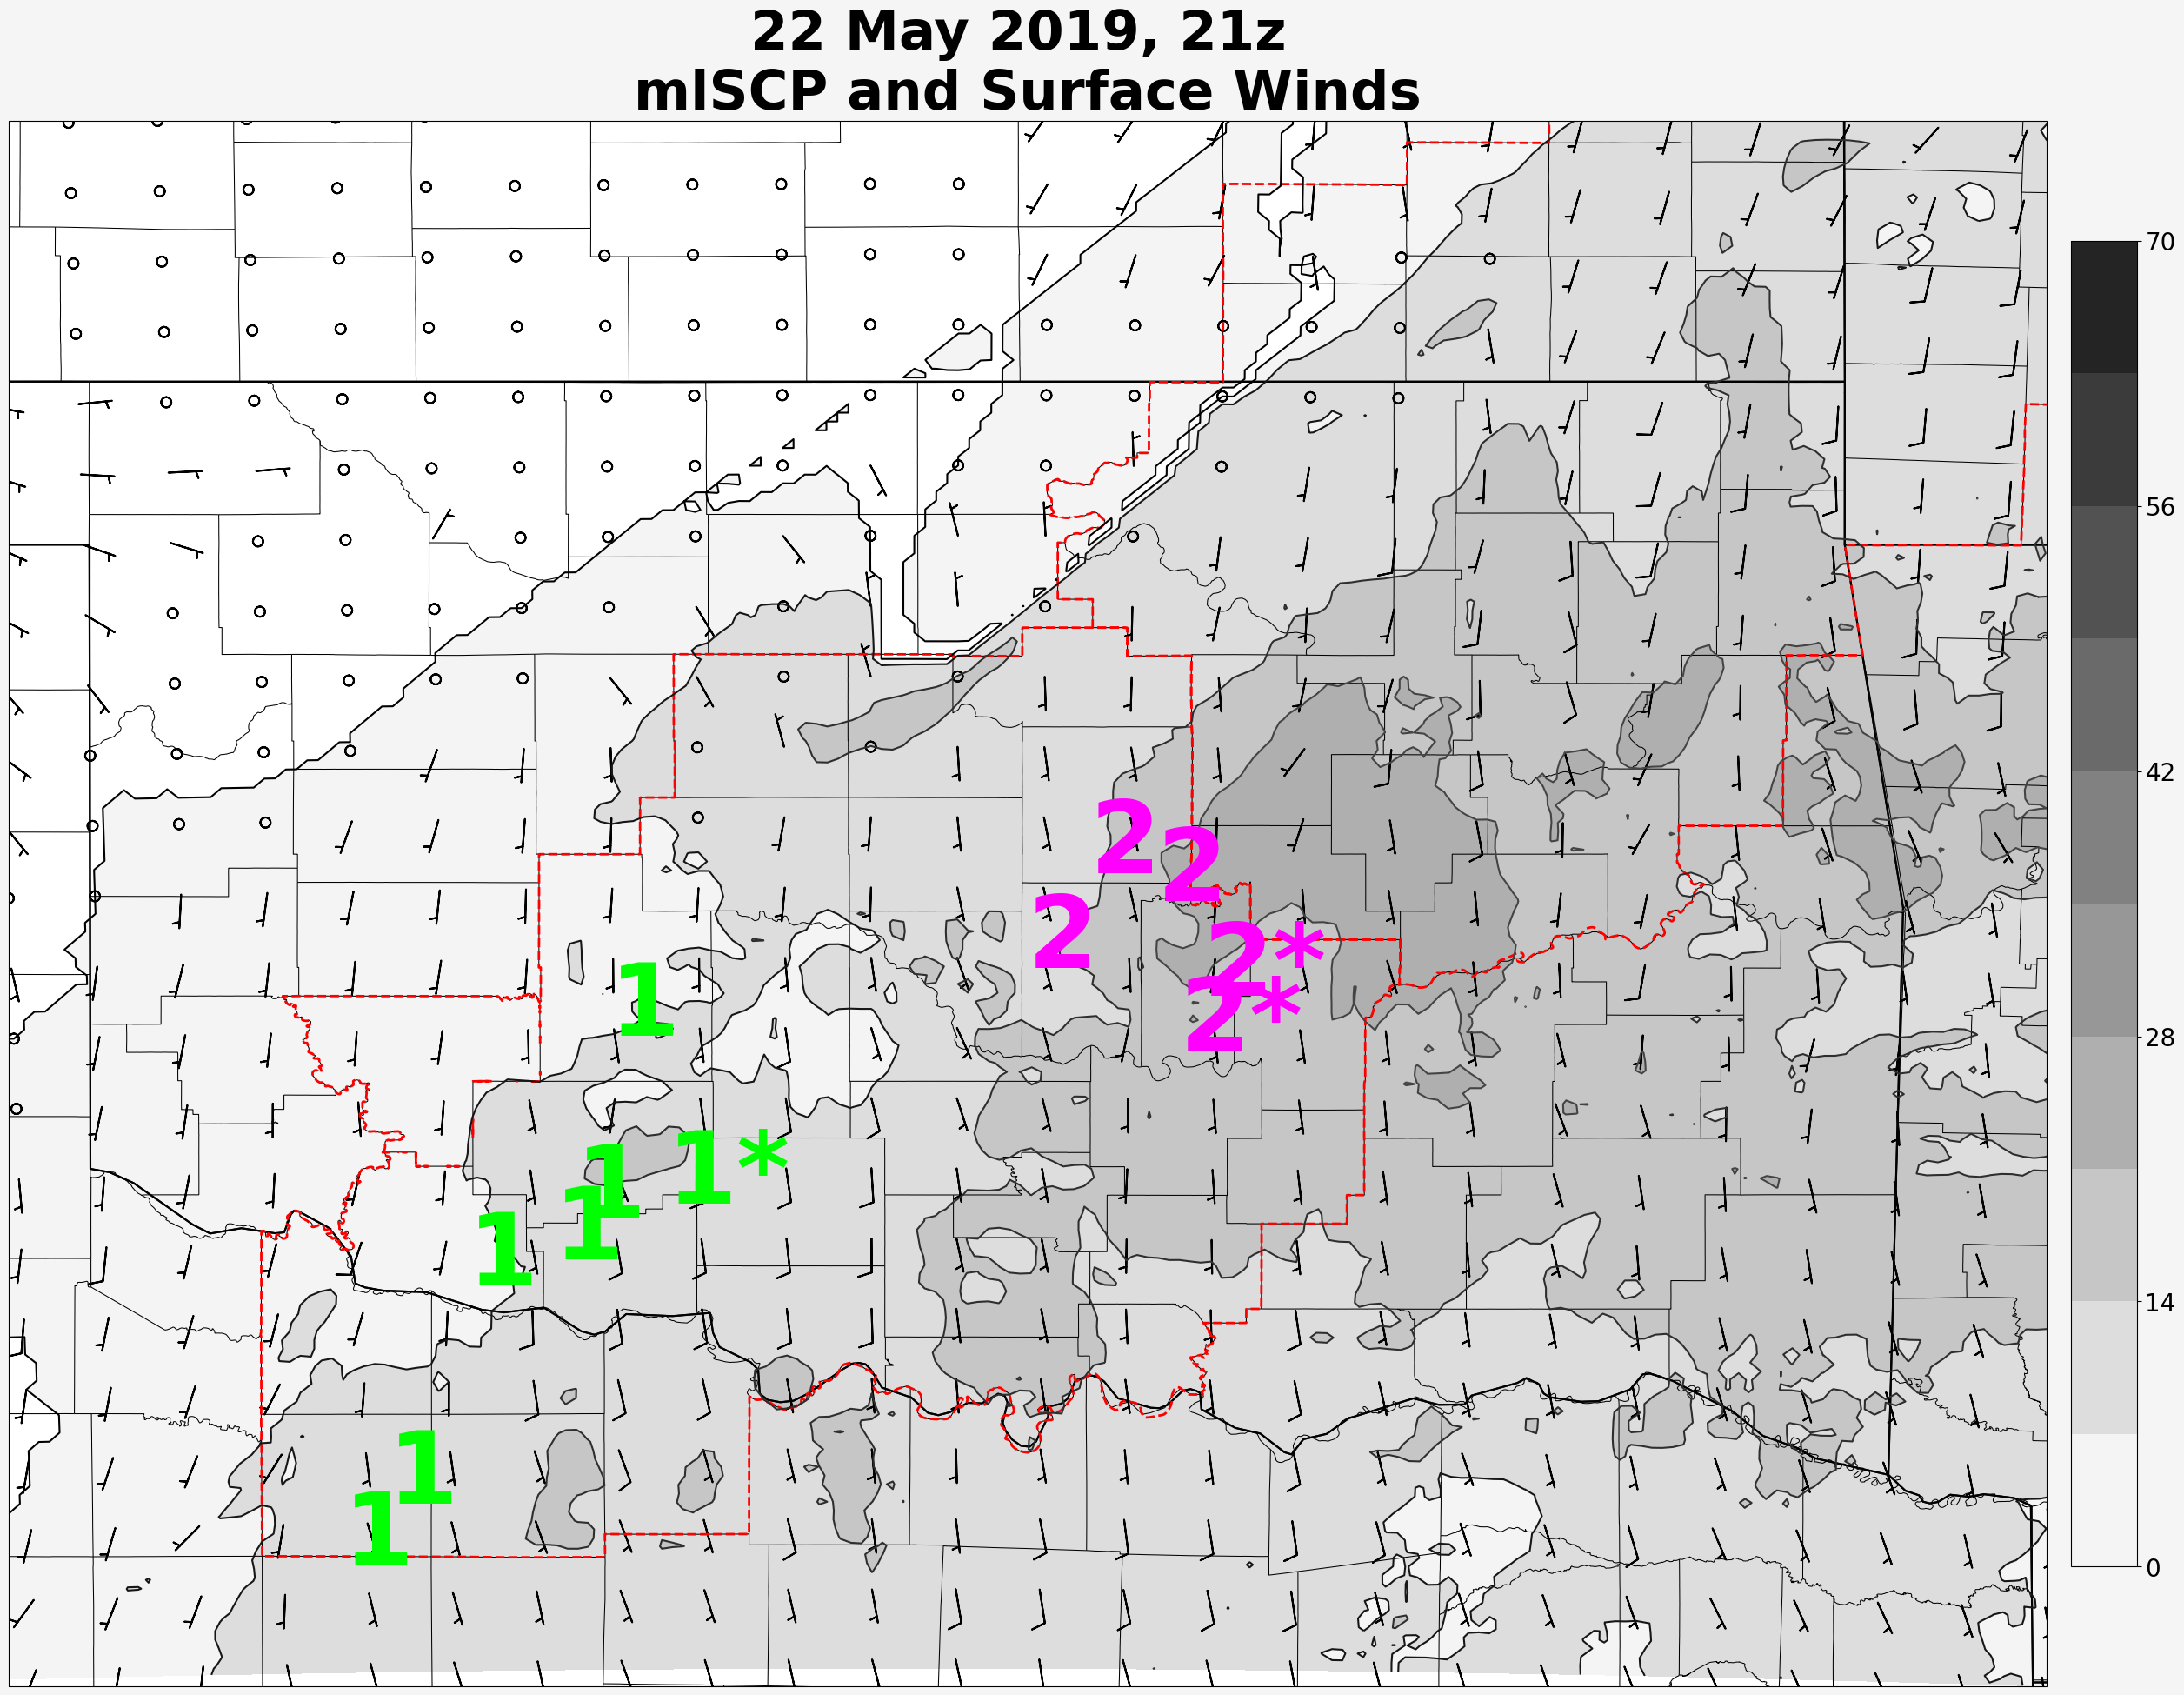

In [61]:
#for i in hours:
df1 = pd.read_csv(r"C:\Users\kyled\Desktop\CSV_Plot_Lists\Round2.csv")

i = 21
day0 = "22"

#folder = r"C:\Users\kyled\Desktop\RAPout_Arrays\_"+str(i)
folder = r"C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_"+str(i)
files = glob.glob(folder+'\*.csv')
for j in range(0, len(files)):

    df = pd.read_csv(files[j],header = None)
    df.fillna(0,inplace=True)
    data = df.to_numpy()
    title = str(day0)+" May 2019, "+str(i)+"z \n" + df1['param'][j] +" and Surface Winds"
    fig=plt.figure(figsize = (36,36))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(title, fontsize=45, fontweight='bold')
    ax.set_xticks([-180,-120,-60,0,60,120,180])
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
    ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
    ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
    ax.set_extent([-100.25, -94.0, 33.0, 37.8])

    #cf = ax.contour(lon, lat, data, levels = levels, cmap=cmap2) # Make a filled contour plot
    #cf1 = ax.contourf(lon, lat, data, levels = levels, cmap=cmap1) # Make a filled contour plot
    levels = np.arange(df1['lowBound'][j], df1['highBound'][j], df1['cf_levels'][j])
    if files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr0'+str(i)+'_Inhibition_0_mlCIN.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr0'+str(i)+'_Inhibition_1_muCIN.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_Inhibition_0_mlCIN.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_Inhibition_1_muCIN.csv'):
        cmap_1 = plt.get_cmap('gray')
        cmap_2 = plt.get_cmap('binary')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
    else:
        cmap_1 = plt.get_cmap('binary')
        cmap_2 = plt.get_cmap('gray')
        cmap1 = truncate_colormap(cmap_1, 0, 0.90)
        cmap2 = truncate_colormap(cmap_2, 0, 0.90)
        cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
        cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot

    #cf = ax.contour(lon1, lat1, data, 10, cmap=cmap2) # Make a filled contour plot
    #cf1 = ax.contourf(lon1, lat1, data, 10, cmap=cmap1) # Make a filled contour plot
    
    if files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr0'+str(i)+'_Moisture_11_meanRH1_3kmAGL.csv'):
        ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[10][::8,::8], v = vwnd[10][::8,::8], length=7.5,linewidth=1.5, color='black')
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr0'+str(i)+'_ThetaE_8_meanThetaE1_3km.csv'):
        ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[10][::8,::8], v = vwnd[10][::8,::8], length=7.5,linewidth=1.5, color='black')   
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_Moisture_11_meanRH1_3kmAGL.csv'):
        ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[10][::8,::8], v = vwnd[10][::8,::8], length=7.5,linewidth=1.5, color='black')   
    elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_ThetaE_8_meanThetaE1_3km.csv'):
        ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[10][::8,::8], v = vwnd[10][::8,::8], length=7.5,linewidth=1.5, color='black')          
    else:
        ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=7.5,linewidth=1.5, color='black') 

    cbar = plt.colorbar(cf1, extend='both', shrink=0.55, pad=0.01)
    cbar.ax.tick_params(labelsize=20)

    soundings = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs_QC.csv', usecols=['Time','Grouping', 'Lat', 'Lon','Supercell'])
    xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
    if len(xGRP1non) != 0:
        for k in range(0,len(xGRP1non)):
            plt.text(xGRP1non['Lon'].iloc[k],xGRP1non['Lat'].iloc[k],'1',fontsize=84,fontweight='bold', color='lime')
    xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
    if len(xGRP1sup) != 0:
        for k in range(0,len(xGRP1sup)):
            plt.text(xGRP1sup['Lon'].iloc[k],xGRP1sup['Lat'].iloc[k],'1*',fontsize=84,fontweight='bold', color='lime')      

    xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
    if len(xGRP2non) != 0:
        for k in range(0,len(xGRP2non)):
            plt.text(xGRP2non['Lon'].iloc[k],xGRP2non['Lat'].iloc[k],'2',fontsize=84,fontweight='bold', color='fuchsia')
    xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
    if len(xGRP2sup) != 0:
        for k in range(0,len(xGRP2sup)):
            plt.text(xGRP2sup['Lon'].iloc[k],xGRP2sup['Lat'].iloc[k],'2*',fontsize=84,fontweight='bold', color='fuchsia')

    xGRP4non = soundings[soundings.Time==i][soundings.Grouping==4][soundings.Supercell=='N']
    if len(xGRP4non) != 0:
        for k in range(0,len(xGRP4non)):
            plt.text(xGRP4non['Lon'].iloc[k],xGRP4non['Lat'].iloc[k],'4',fontsize=84,fontweight='bold', color='lime')
    xGRP4sup = soundings[soundings.Time==i][soundings.Grouping==4][soundings.Supercell=='Y']
    if len(xGRP4sup) != 0:
        for k in range(0,len(xGRP4sup)):
            plt.text(xGRP4sup['Lon'].iloc[k],xGRP4sup['Lat'].iloc[k],'4*',fontsize=84,fontweight='bold', color='lime')

    if i != 22:
        xGRP5non = soundings[soundings.Time==i][soundings.Grouping==5][soundings.Supercell=='N']
        if len(xGRP5non) != 0:
            for k in range(0,len(xGRP5non)):
                plt.text(xGRP5non['Lon'].iloc[k],xGRP5non['Lat'].iloc[k],'5',fontsize=84,fontweight='bold', color='lime')
        xGRP5sup = soundings[soundings.Time==i][soundings.Grouping==5][soundings.Supercell=='Y']
        if len(xGRP5sup) != 0:
            for k in range(0,len(xGRP5sup)):
                plt.text(xGRP5sup['Lon'].iloc[k],xGRP5sup['Lat'].iloc[k],'5*',fontsize=84,fontweight='bold', color='lime')
                
    if i == 22:
        plt.plot(-99.5684, 32.81669+0.33, marker=r'$\downarrow$', markersize = 72, color="lime")
        plt.text(-99.59, 32.81669+0.51, '5', fontsize=84,fontweight='bold', color='lime')

    if i == 22:        
        xGRP7non = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='N']
        if len(xGRP7non) != 0:
            for k in range(0,len(xGRP7non)):
                plt.text(xGRP7non['Lon'].iloc[k],xGRP7non['Lat'].iloc[k],'7',fontsize=84,fontweight='bold', color='fuchsia')
        xGRP7sup = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='Y']
        if len(xGRP7sup) != 0:
            for k in range(0,len(xGRP7sup)):
                plt.text(xGRP7sup['Lon'].iloc[k],xGRP7sup['Lat'].iloc[k],'7*',fontsize=84,fontweight='bold', color='fuchsia')

    if i == 23:        
        xGRP7non = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='N']
        if len(xGRP7non) != 0:
            for k in range(0,len(xGRP7non)):
                plt.text(xGRP7non['Lon'].iloc[k],xGRP7non['Lat'].iloc[k],'7',fontsize=84,fontweight='bold', color='fuchsia')
        xGRP7sup = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='Y']
        if len(xGRP7sup) != 0:
            for k in range(0,len(xGRP7sup)):
                plt.text(xGRP7sup['Lon'].iloc[k],xGRP7sup['Lat'].iloc[k],'7*',fontsize=84,fontweight='bold', color='fuchsia')
                
    if i == 0:        
        xGRP7non = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='N']
        if len(xGRP7non) != 0:
            for k in range(0,len(xGRP7non)):
                plt.text(xGRP7non['Lon'].iloc[k],xGRP7non['Lat'].iloc[k],'7',fontsize=84,fontweight='bold', color='fuchsia')
        xGRP7sup = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='Y']
        if len(xGRP7sup) != 0:
            for k in range(0,len(xGRP7sup)):
                plt.text(xGRP7sup['Lon'].iloc[k],xGRP7sup['Lat'].iloc[k],'7*',fontsize=84,fontweight='bold', color='fuchsia')
                
                
    xGRP8non = soundings[soundings.Time==i][soundings.Grouping==8][soundings.Supercell=='N']
    if len(xGRP8non) != 0:
        for k in range(0,len(xGRP8non)):
            plt.text(xGRP8non['Lon'].iloc[k],xGRP8non['Lat'].iloc[k],'8',fontsize=84,fontweight='bold', color='fuchsia')
    xGRP8sup = soundings[soundings.Time==i][soundings.Grouping==8][soundings.Supercell=='Y']
    if len(xGRP8sup) != 0:
        for k in range(0,len(xGRP8sup)):
            plt.text(xGRP8sup['Lon'].iloc[k],xGRP8sup['Lat'].iloc[k],'8*',fontsize=84,fontweight='bold', color='fuchsia')

    xGRP9non = soundings[soundings.Time==i][soundings.Grouping==9][soundings.Supercell=='N']
    if len(xGRP9non) != 0:
        for k in range(0,len(xGRP9non)):
            plt.text(xGRP9non['Lon'].iloc[k],xGRP9non['Lat'].iloc[k],'9',fontsize=84,fontweight='bold', color='fuchsia')
    xGRP9sup = soundings[soundings.Time==i][soundings.Grouping==9][soundings.Supercell=='Y']
    if len(xGRP9sup) != 0:
        for k in range(0,len(xGRP9sup)):
            plt.text(xGRP9sup['Lon'].iloc[k],xGRP9sup['Lat'].iloc[k],'9*',fontsize=84,fontweight='bold', color='fuchsia')

    xGRP11non = soundings[soundings.Time==i][soundings.Grouping==11][soundings.Supercell=='N']
    if len(xGRP11non) != 0:
        for k in range(0,len(xGRP11non)):
            plt.text(xGRP11non['Lon'].iloc[k],xGRP11non['Lat'].iloc[k],'11',fontsize=84,fontweight='bold', color='lime')
    xGRP11sup = soundings[soundings.Time==i][soundings.Grouping==11][soundings.Supercell=='Y']
    if len(xGRP11sup) != 0:
        for k in range(0,len(xGRP11sup)):
            plt.text(xGRP11sup['Lon'].iloc[k],xGRP11sup['Lat'].iloc[k],'11*',fontsize=84,fontweight='bold', color='lime')

    fig.set_facecolor('whitesmoke')
    #plt.legend(loc='upper left', fontsize = 35,shadow=True)
    #fig.tight_layout()
    plt.savefig(r"C:/Users/kyled/Desktop/HRRROuts/0z/"+str(df1['Category'][j])+"_"+str(df1['param'][j])+"_"+str(i)+".png", bbox_inches='tight')
    #plt.show()
    plt.close(fig)
    plt.clf()

    print(df1['param'][j], i, j)
    j+=1

In [71]:
#for i in hours:
df1 = pd.read_csv(r"C:\Users\kyled\Desktop\CSV_Plot_Lists\Round2.csv")

i = 0
day0 = "23"

#folder = r"C:\Users\kyled\Desktop\RAPout_Arrays\_"+str(i)
folder = r"C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_"+str(i)
files = glob.glob(folder+'\*.csv')
#for j in range(0, len(files)):

df = pd.read_csv(files[-3],header = None)
df.fillna(0,inplace=True)
data = df.to_numpy()
title = str(day0)+" May 2019, "+str(i)+"z \n 700 hPa Temperature and Wind"
fig=plt.figure(figsize = (36,36))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(title, fontsize=45, fontweight='bold')
ax.set_xticks([-180,-120,-60,0,60,120,180])
ax.set_yticks([-90,-60,-30,0,30,60,90])
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
ax.set_extent([-100.25, -94.0, 33.0, 37.8])

#cf = ax.contour(lon, lat, data, levels = levels, cmap=cmap2) # Make a filled contour plot
#cf1 = ax.contourf(lon, lat, data, levels = levels, cmap=cmap1) # Make a filled contour plot
levels = np.arange(6, 16, 1)
# if files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr0'+str(i)+'_Inhibition_0_mlCIN.csv'):
#     cmap_1 = plt.get_cmap('gray')
#     cmap_2 = plt.get_cmap('binary')
#     cmap1 = truncate_colormap(cmap_1, 0, 0.90)
#     cmap2 = truncate_colormap(cmap_2, 0, 0.90)
#     cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
#     cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
# elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr0'+str(i)+'_Inhibition_1_muCIN.csv'):
#     cmap_1 = plt.get_cmap('gray')
#     cmap_2 = plt.get_cmap('binary')
#     cmap1 = truncate_colormap(cmap_1, 0, 0.90)
#     cmap2 = truncate_colormap(cmap_2, 0, 0.90)
#     cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
#     cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
# elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_Inhibition_0_mlCIN.csv'):
#     cmap_1 = plt.get_cmap('gray')
#     cmap_2 = plt.get_cmap('binary')
#     cmap1 = truncate_colormap(cmap_1, 0, 0.90)
#     cmap2 = truncate_colormap(cmap_2, 0, 0.90)
#     cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
#     cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
# elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_Inhibition_1_muCIN.csv'):
#     cmap_1 = plt.get_cmap('gray')
#     cmap_2 = plt.get_cmap('binary')
#     cmap1 = truncate_colormap(cmap_1, 0, 0.90)
#     cmap2 = truncate_colormap(cmap_2, 0, 0.90)
#     cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
#     cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot
# else:
cmap_1 = plt.get_cmap('binary')
cmap_2 = plt.get_cmap('gray')
cmap1 = truncate_colormap(cmap_1, 0, 0.90)
cmap2 = truncate_colormap(cmap_2, 0, 0.90)
cf = ax.contour(lon1, lat1, data, levels=levels, cmap=cmap2) # Make a filled contour plot
cf1 = ax.contourf(lon1, lat1, data, levels=levels, cmap=cmap1) # Make a filled contour plot

#cf = ax.contour(lon1, lat1, data, 10, cmap=cmap2) # Make a filled contour plot
#cf1 = ax.contourf(lon1, lat1, data, 10, cmap=cmap1) # Make a filled contour plot

# if files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr0'+str(i)+'_Moisture_11_meanRH1_3kmAGL.csv'):
#     ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[10][::8,::8], v = vwnd[10][::8,::8], length=7.5,linewidth=1.5, color='black')
# elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr0'+str(i)+'_ThetaE_8_meanThetaE1_3km.csv'):
#     ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[10][::8,::8], v = vwnd[10][::8,::8], length=7.5,linewidth=1.5, color='black')   
# elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_Moisture_11_meanRH1_3kmAGL.csv'):
#     ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[10][::8,::8], v = vwnd[10][::8,::8], length=7.5,linewidth=1.5, color='black')   
# elif files[j] == str(r'C:\Users\kyled\Desktop\HRRROuts\Hourly_Array_'+str(i)+'\hr'+str(i)+'_ThetaE_8_meanThetaE1_3km.csv'):
#     ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[10][::8,::8], v = vwnd[10][::8,::8], length=7.5,linewidth=1.5, color='black')          
#else:
df6 = pd.read_csv(files[-2],header = None)
df6.fillna(0,inplace=True)
data6 = df6.to_numpy()

df7 = pd.read_csv(files[-1],header = None)
df7.fillna(0,inplace=True)
data7 = df7.to_numpy()

ax.barbs(x = lon[327:513,790:1040][::8,::8], y = lat[327:513,790:1040][::8,::8], u = data6[::8,::8], v = data7[::8,::8], length=7.5,linewidth=1.5, color='black') 

cbar = plt.colorbar(cf1, extend='both', shrink=0.55, pad=0.01)
cbar.ax.tick_params(labelsize=20)

soundings = pd.read_csv('C:/Users/kyled/Desktop/NI_Points_CSVs/5_22_VerticalProfs_QC.csv', usecols=['Time','Grouping', 'Lat', 'Lon','Supercell'])
xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
if len(xGRP1non) != 0:
    for k in range(0,len(xGRP1non)):
        plt.text(xGRP1non['Lon'].iloc[k],xGRP1non['Lat'].iloc[k],'1',fontsize=84,fontweight='bold', color='lime')
xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
if len(xGRP1sup) != 0:
    for k in range(0,len(xGRP1sup)):
        plt.text(xGRP1sup['Lon'].iloc[k],xGRP1sup['Lat'].iloc[k],'1*',fontsize=84,fontweight='bold', color='lime')      

xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
if len(xGRP2non) != 0:
    for k in range(0,len(xGRP2non)):
        plt.text(xGRP2non['Lon'].iloc[k],xGRP2non['Lat'].iloc[k],'2',fontsize=84,fontweight='bold', color='fuchsia')
xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
if len(xGRP2sup) != 0:
    for k in range(0,len(xGRP2sup)):
        plt.text(xGRP2sup['Lon'].iloc[k],xGRP2sup['Lat'].iloc[k],'2*',fontsize=84,fontweight='bold', color='fuchsia')

xGRP4non = soundings[soundings.Time==i][soundings.Grouping==4][soundings.Supercell=='N']
if len(xGRP4non) != 0:
    for k in range(0,len(xGRP4non)):
        plt.text(xGRP4non['Lon'].iloc[k],xGRP4non['Lat'].iloc[k],'4',fontsize=84,fontweight='bold', color='lime')
xGRP4sup = soundings[soundings.Time==i][soundings.Grouping==4][soundings.Supercell=='Y']
if len(xGRP4sup) != 0:
    for k in range(0,len(xGRP4sup)):
        plt.text(xGRP4sup['Lon'].iloc[k],xGRP4sup['Lat'].iloc[k],'4*',fontsize=84,fontweight='bold', color='lime')

if i != 22:
    xGRP5non = soundings[soundings.Time==i][soundings.Grouping==5][soundings.Supercell=='N']
    if len(xGRP5non) != 0:
        for k in range(0,len(xGRP5non)):
            plt.text(xGRP5non['Lon'].iloc[k],xGRP5non['Lat'].iloc[k],'5',fontsize=84,fontweight='bold', color='lime')
    xGRP5sup = soundings[soundings.Time==i][soundings.Grouping==5][soundings.Supercell=='Y']
    if len(xGRP5sup) != 0:
        for k in range(0,len(xGRP5sup)):
            plt.text(xGRP5sup['Lon'].iloc[k],xGRP5sup['Lat'].iloc[k],'5*',fontsize=84,fontweight='bold', color='lime')

if i == 22:
    plt.plot(-99.5684, 32.81669+0.33, marker=r'$\downarrow$', markersize = 72, color="lime")
    plt.text(-99.59, 32.81669+0.51, '5', fontsize=84,fontweight='bold', color='lime')

if i == 22:        
    xGRP7non = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='N']
    if len(xGRP7non) != 0:
        for k in range(0,len(xGRP7non)):
            plt.text(xGRP7non['Lon'].iloc[k],xGRP7non['Lat'].iloc[k],'7',fontsize=84,fontweight='bold', color='fuchsia')
    xGRP7sup = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='Y']
    if len(xGRP7sup) != 0:
        for k in range(0,len(xGRP7sup)):
            plt.text(xGRP7sup['Lon'].iloc[k],xGRP7sup['Lat'].iloc[k],'7*',fontsize=84,fontweight='bold', color='fuchsia')

if i == 23:        
    xGRP7non = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='N']
    if len(xGRP7non) != 0:
        for k in range(0,len(xGRP7non)):
            plt.text(xGRP7non['Lon'].iloc[k],xGRP7non['Lat'].iloc[k],'7',fontsize=84,fontweight='bold', color='fuchsia')
    xGRP7sup = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='Y']
    if len(xGRP7sup) != 0:
        for k in range(0,len(xGRP7sup)):
            plt.text(xGRP7sup['Lon'].iloc[k],xGRP7sup['Lat'].iloc[k],'7*',fontsize=84,fontweight='bold', color='fuchsia')

if i == 0:        
    xGRP7non = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='N']
    if len(xGRP7non) != 0:
        for k in range(0,len(xGRP7non)):
            plt.text(xGRP7non['Lon'].iloc[k],xGRP7non['Lat'].iloc[k],'7',fontsize=84,fontweight='bold', color='fuchsia')
    xGRP7sup = soundings[soundings.Time==i][soundings.Grouping==7][soundings.Supercell=='Y']
    if len(xGRP7sup) != 0:
        for k in range(0,len(xGRP7sup)):
            plt.text(xGRP7sup['Lon'].iloc[k],xGRP7sup['Lat'].iloc[k],'7*',fontsize=84,fontweight='bold', color='fuchsia')


xGRP8non = soundings[soundings.Time==i][soundings.Grouping==8][soundings.Supercell=='N']
if len(xGRP8non) != 0:
    for k in range(0,len(xGRP8non)):
        plt.text(xGRP8non['Lon'].iloc[k],xGRP8non['Lat'].iloc[k],'8',fontsize=84,fontweight='bold', color='fuchsia')
xGRP8sup = soundings[soundings.Time==i][soundings.Grouping==8][soundings.Supercell=='Y']
if len(xGRP8sup) != 0:
    for k in range(0,len(xGRP8sup)):
        plt.text(xGRP8sup['Lon'].iloc[k],xGRP8sup['Lat'].iloc[k],'8*',fontsize=84,fontweight='bold', color='fuchsia')

xGRP9non = soundings[soundings.Time==i][soundings.Grouping==9][soundings.Supercell=='N']
if len(xGRP9non) != 0:
    for k in range(0,len(xGRP9non)):
        plt.text(xGRP9non['Lon'].iloc[k],xGRP9non['Lat'].iloc[k],'9',fontsize=84,fontweight='bold', color='fuchsia')
xGRP9sup = soundings[soundings.Time==i][soundings.Grouping==9][soundings.Supercell=='Y']
if len(xGRP9sup) != 0:
    for k in range(0,len(xGRP9sup)):
        plt.text(xGRP9sup['Lon'].iloc[k],xGRP9sup['Lat'].iloc[k],'9*',fontsize=84,fontweight='bold', color='fuchsia')

xGRP11non = soundings[soundings.Time==i][soundings.Grouping==11][soundings.Supercell=='N']
if len(xGRP11non) != 0:
    for k in range(0,len(xGRP11non)):
        plt.text(xGRP11non['Lon'].iloc[k],xGRP11non['Lat'].iloc[k],'11',fontsize=84,fontweight='bold', color='lime')
xGRP11sup = soundings[soundings.Time==i][soundings.Grouping==11][soundings.Supercell=='Y']
if len(xGRP11sup) != 0:
    for k in range(0,len(xGRP11sup)):
        plt.text(xGRP11sup['Lon'].iloc[k],xGRP11sup['Lat'].iloc[k],'11*',fontsize=84,fontweight='bold', color='lime')

fig.set_facecolor('whitesmoke')
#plt.legend(loc='upper left', fontsize = 35,shadow=True)
#fig.tight_layout()
plt.savefig(r"C:/Users/kyled/Desktop/HRRROuts/0z/Inhibition_700mbTemp_"+str(i)+".png", bbox_inches='tight')
#plt.show()
plt.close(fig)
plt.clf()

#print(df1['param'][j], i, j)

C:\Users\kyled\AppData\Local\Temp\ipykernel_13768\2473613969.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_13768\2473613969.py:96: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1sup = soundings[soundings.Time==i][soundings.Grouping==1][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_13768\2473613969.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2non = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='N']
C:\Users\kyled\AppData\Local\Temp\ipykernel_13768\2473613969.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP2sup = soundings[soundings.Time==i][soundings.Grouping==2][soundings.Supercell=='Y']
C:\Users\kyled\AppData\Local\Temp\ipykernel_13768\24736139

<Figure size 640x480 with 0 Axes>

In [40]:
print(lon[327:513,790:1040][::8,::8].shape)
print(lat[327:513,790:1040][::8,::8].shape)
print(data6[::8,::8].shape)
print(data7[::8,::8].shape)

(24, 32)
(24, 32)
(24, 32)
(24, 32)
